In [1]:
from __future__ import print_function

import math
import numpy as np
import os
import sys
import fnmatch
import scipy.optimize as op
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn,unique
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
from astropy import units as u
#matplotlib.use('Agg')
import matplotlib.pyplot as pl
%matplotlib inline

import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from linetools.spectra.xspectrum1d import XSpectrum1D
import model_NaI
import model_fitter
import continuum_normalize_NaI
#import NaImcmc_read_fits
#import NaImcmc_fitwrapper
#import ew_NaI_allspax
import pdb
import corner 
import glob
import os
from kcwi_jnb import cube
from kcwi_jnb import transform
from astropy.table import Table, vstack

pl.rcParams['figure.figsize'] = (8,6)
pl.rc('axes', labelsize = 16)
pl.rc('axes', titlesize = 18)
#pl.rc('axes', titleweight = 'bold')
pl.rc('axes', lw = 1)
pl.rc('xtick',labelsize=20)
pl.rc('ytick',labelsize=20)
pl.rcParams["font.family"] = "Times New Roman"

import numpy as np
import pandas as pd
import scipy.stats as st
import numba

import emcee
import ptemcee

import bebi103

import extinction
import bokeh.io
import bokeh.plotting
from bokeh.models import ColumnDataSource, CustomJS, Slider,Div,SingleIntervalTicker,ColorBar
bokeh.io.output_notebook()


/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/bebi103/viz.py:38: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

In [2]:
# directory path for NGC 4030 and NGC 1042
path = '/Users/erickaguirre/Desktop/DAP_outputs/'
bin_dir = 'output0.6_'
#bin_dir = 'output2.0_'
#bin_dir = 'output2.0_'
gal_name = 'NGC4030_NOISM_err_corr'
#gal_name = 'NGC1042'
#gal_sub_dir = '/SQUARE2.0-MILESHC-MASTARSSP/1/2/'
gal_sub_dir = '/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/'
#gal_sub_dir = '/SQUARE0.6-MILESHC-MASTARSSP/1/1/'
#gal_sub_dir = '/SQUARE2.0-MILESHC-MASTARSSP/1/1/'

# For continuum-normalization around NaI
# wavelength continuum fitting range outside of NaI region
blim = [5850.0,5870.0]
rlim = [5910.0,5930.0]
# wavelength fitting range inside of NaI region
fitlim = [5880.0,5910.0]
# speed of light in km/s
c = 2.998e5
# Na I doublet vacuum absorption wavelengths 
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms
redshift = 0.00489 

# log cube model and data file path
#log_cube_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARSSP.fits'
#log_cube_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-LOGCUBE-SQUARE1.0-MILESHC-MASTARSSP.fits'
log_cube_fil = path + bin_dir + gal_name + \
                gal_sub_dir + 'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits'
#log_cube_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-2-LOGCUBE-SQUARE2.0-MILESHC-MASTARSSP.fits'
log_cube = fits.open(log_cube_fil)
# log maps file path
#log_maps_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARSSP.fits.gz'
#log_maps_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-MAPS-SQUARE1.0-MILESHC-MASTARSSP.fits.gz'
log_maps_fil = path + bin_dir + gal_name + \
                gal_sub_dir + 'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits.gz'
#log_maps_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-2-MAPS-SQUARE2.0-MILESHC-MASTARSSP.fits.gz'
# log maps file 
hdu_map = fits.open(log_maps_fil)
# bin ID has multiple layers of the same bin id map so use first one
binid_map = hdu_map['BINID'].data[0]
ppxf_v_map = hdu_map['STELLAR_VEL'].data

In [6]:
ra_map = np.transpose(hdu_map['BIN_LWSKYCOO'].data[0])
ra_map

array([[ 0.    ,  0.    ,  0.    , ..., 32.2008,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., 32.2008,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., 32.2008,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
      dtype=float32)

In [64]:
np.max(np.transpose(hdu_map['SPX_SKYCOO'].data[1]))

32.60005

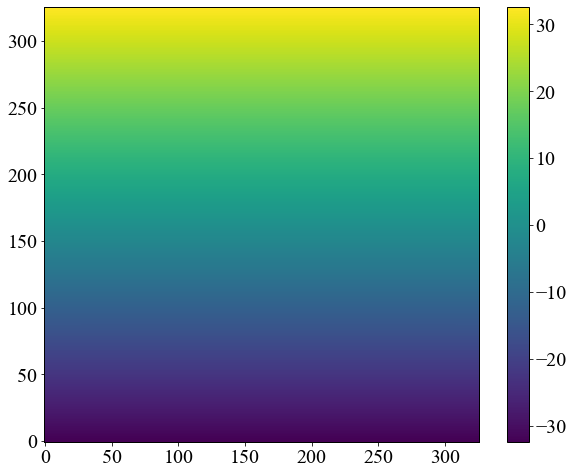

In [164]:
pl.imshow(hdu_map['SPX_SKYCOO'].data[1],origin='lower');
pl.colorbar();

In [18]:
hdu_map['SPX_ELLCOO'].data[3][0,325] / 70

2.9199120657784596

In [19]:
hdu_map['SPX_ELLCOO'].data[3][325,0] / 70

0.3420766830444336

In [28]:
hdu_map['SPX_ELLCOO'].data[3][325,50] / 70

0.14710336412702288

In [4]:
#hdu_map['EMLINE_GFLUX'].header

In [5]:
# path1 = '/Users/erickaguirre/Desktop/'
# file_path = path1 + 'ADP.2017-06-06T14_10_15.061.fits'
# file = fits.open(file_path)
# f#ile[0].header

In [11]:
np.max(hdu_map['SPX_ELLCOO'].data[2])

4.3954477

In [7]:
# obtain stellar velocity, stellar dispersion and bin id data from the galaxy
stellar_vel =  hdu_map['STELLAR_VEL'].data
stell_err = ivar = np.sqrt(1/hdu_map['STELLAR_VEL_IVAR'].data)

stellar_sigma = hdu_map['STELLAR_SIGMA'].data
stell_sig_err = np.sqrt(1/hdu_map['STELLAR_SIGMA_IVAR'].data)
binid_map = hdu_map['BINID'].data[0]

# emission line header dictionary
emline = {}
for k, v in hdu_map['EMLINE_GFLUX'].header.items():
    if k[0] == 'C':
        try:
            i = int(k[1:])-1
        except ValueError:
            continue
        emline[v] = i
        
# H-alpha emission line flux from MUSE cube (1E-17 erg/s/cm^2/spaxel)
# 23rd index = 24 channel
halpha_map = hdu_map['EMLINE_GFLUX'].data[emline['Ha-6564'],:,:]
# H-beta emission line flux from MUSE cube
hbeta_map = hdu_map['EMLINE_GFLUX'].data[emline['Hb-4862'],:,:]

#def get_SFR(halpha_map,hbeta_map,method,method2):
    
#     if method == 'ccm':
#     halpha and hbeta emissionlines sdss website https://classic.sdss.org/dr7/products/spectra/vacwavelength.html
# k_lambda_halpha = extinction.ccm89(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# k_lambda_hbeta = extinction.ccm89(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
#     elif method == 'odonnell':
# k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
method = 'calzetti'
if method == 'calzetti':
    # extinction in magnitudes using Calzettie et al. 2000 extinction curve
    k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
    k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
#     elif method == 'fitzpatrick':
#         k_lambda_halpha = extinction.fitzpatrick99(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
#         k_lambda_hbeta = extinction.fitzpatrick99(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
#     elif method == 'fitzpatrick_massa':
#         # assuming r_v = 3.1
#         k_lambda_halpha = extinction.fm07(np.array([6564.614]),a_v = 4.05, unit='aa')
#         k_lambda_hbeta = extinction.fm07(np.array([4862.721]),a_v = 4.05, unit='aa')

    #dust attenuation map
# if method2 == 'method1':
ebv_map = 0.935 * np.log( (halpha_map/hbeta_map) /2.86 )
# elif method2 == 'method2':
# ebv_map = (1.086/(k_lambda_hbeta - k_lambda_halpha) ) * np.log( (halpha_map/hbeta_map) /2.86 )
# ebv_map = (2.5 /(k_lambda_hbeta - k_lambda_halpha) ) * np.log10( (halpha_map/hbeta_map) /2.86 )
# any E(B-V) value less than 0 is unrealistic, and must be changed to 0
ebv_map[ebv_map < 0] = 0.
    # corrected h-alpha map 
# halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
# replace NaN values w/ finite values
ebv_map[np.logical_not(np.isfinite(ebv_map))] = -999
# use good values in original h-alpha map to replace NaN values
# in corrected h-alpha map due to nan values from ebv map
nan_indx = np.where(np.isfinite(halpha_map_corrected) == False)
halpha_map_corrected[nan_indx] = halpha_map[nan_indx]

# recessional velocity of NGC 4030 (SIMBAD value) (km/s)
v_recess = 1467.2 * (u.kilometer / u.second)
# Hubble constant (km/s/Mpc)
H_0 = 70 * (u.kilometer / (u.second * 1e6 * u.parsec) )
# NGC4030 distance
#r = (v_recess / H_0).to(u.centimeter)
r = (29.99 * 1e6 * u.parsec).to(u.centimeter)
# h-alpha luminosity map (ergs/s)
L_halpha = 4*np.pi * r**2 * halpha_map_corrected * ( (1e-17 * u.erg) / (u.second * u.centimeter**2) )
# SFR map from h-alpha luminosity in units of M_sun / year
#SFR_map = 7.94*10**(-42) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
SFR_map = 10**(-41.27) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
    #return np.sum( SFR_map.flatten() )

logSFR_map = np.log10(L_halpha.value) - 41.27
logSFR_map[np.logical_not(np.isfinite(logSFR_map))] = -999
halpha_map_corrected[np.logical_not(np.isfinite(halpha_map_corrected))] = -999

# SNR per spaxel and bin ID
snr_spxl_map = hdu_map['SPX_SNR'].data
snr_bin_map = hdu_map['BIN_SNR'].data

# # obtain image data averaged around Na I region from MUSE cube
# dc = cube.DataCube(inp=log_cube_fil)
# n_band = transform.narrowband(dc, 5880, 5940, mode='median')
# img_data = n_band.data

# obtain flux array from MUSE cube
flux = log_cube['FLUX'].data
model = log_cube['MODEL'].data
ivar = log_cube['IVAR'].data
error = np.sqrt(1/ivar)
wave =log_cube['WAVE'].data

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_46044/2734116082.py:3: RuntimeWarning: divide by zero encountered in divide
  stell_err = ivar = np.sqrt(1/hdu_map['STELLAR_VEL_IVAR'].data)
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_46044/2734116082.py:6: RuntimeWarning: divide by zero encountered in divide
  stell_sig_err = np.sqrt(1/hdu_map['STELLAR_SIGMA_IVAR'].data)
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_46044/2734116082.py:49: RuntimeWarning: divide by zero encountered in divide
  ebv_map = 0.935 * np.log( (halpha_map/hbeta_map) /2.86 )
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_46044/2734116082.py:49: RuntimeWarning: invalid value encountered in divide
  ebv_map = 0.935 * np.log( (halpha_map/hbeta_map) /2.86 )
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_46044/2734116082.py:79: RuntimeWarning: divide by zero encountered in log10
  logSFR_map = np.log10(L_halpha.value) - 41.27
/var/folders/w8/2sm2ctrx0q1_g

In [157]:
np.min(L_halpha[L_halpha>0])

<Quantity 9.50754637e+34 erg / s>

In [87]:
wave[1] - wave[0]

0.8027344

In [8]:
np.sum(SFR_map.flatten())

<Quantity 3.27966357 solMass / yr>

In [7]:
methods = ['ccm','odonnell','calzetti','fitzpatrick','fitzpatrick_massa']

print('Method 1')
for method in methods:
    SFR_tot = get_SFR(halpha_map,hbeta_map,method,method2='method1')
    
    print(str(method)+': '+str(SFR_tot))

Method 1
ccm: 1.8875143576244584 solMass / yr
odonnell: 4.920042994324688 solMass / yr
calzetti: 4.920042994324688 solMass / yr
fitzpatrick: 4.869775882898125 solMass / yr
fitzpatrick_massa: 4.961069934109713 solMass / yr


/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


In [16]:
methods = ['ccm','odonnell','calzetti','fitzpatrick','fitzpatrick_massa']

print('Method 2')
for method in methods:
    SFR_tot = get_SFR(halpha_map,hbeta_map,method,method2='method2')
    
    print(str(method)+': '+str(SFR_tot))

Method 2
ccm: 4.239979305619124 solMass / yr
odonnell: 3.5292733453075997 solMass / yr
calzetti: 3.5292733453075997 solMass / yr
fitzpatrick: 3.5711392197866205 solMass / yr
fitzpatrick_massa: 3.570358103277731 solMass / yr


/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log10


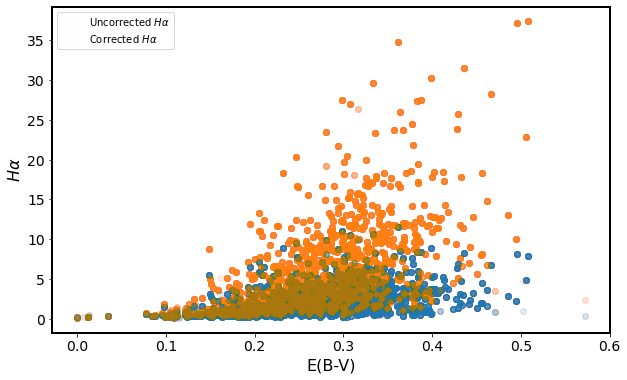

In [85]:
pl.scatter(ebv_map[ebv_map>-999],halpha_map[ebv_map>-999],alpha = 0.01,label = r'Uncorrected $H\alpha$')
pl.scatter(ebv_map[ebv_map>-999],halpha_map_corrected[ebv_map>-999],alpha = 0.01,
           label = r'Corrected $H\alpha$')
pl.xlabel('E(B-V)')
pl.ylabel(r'$H\alpha$')
pl.legend();

In [4]:
# sorting function 
def sort_key(file_path):
    # individually splits the directory and filename from the path given
    dir_path, filename = os.path.split(file_path)
    
    # grab only run number from filename
    run = filename[-8:-4]

    # return only integer run number to sort
    num = int(''.join(i for i in run if i.isdigit()) )
    return run

# compile all the emcee fits and create a Na I velocity map
def mk_table_gasmap(paths):
    
    # fits file path
    fits_paths = sorted(glob.glob(paths+'*'), key = sort_key)

    # combine all the results from each fits file 
    # done in MUSE analysis for one galaxy
    tables = []

    # rest wavelenth for Na I D2 absorption line
    lamrest = 5897.558 # in angstroms

    for fits_file in fits_paths:
        file = fits.open(fits_file)
        data_table = Table(file[1].data)
        tables.append(data_table)

    table_all = vstack(tables)
    
    # get rid of duplicate bins in the table
    table_uniq = unique(table_all, keys=['bin'], keep='last')

    # creates a map that places the gas velocitiy values 
    # to their respective bin_id pixel coordinates
    gas_vel_map = np.zeros(binid_map.shape)

    for binid in table_uniq['bin']:
        index = np.where(binid_map == binid)
        binid_indx = np.where(table_uniq['bin']== binid)
        gas_vel_map[index] = table_uniq['velocities'][binid_indx][0]

    # adds a mean velocity uncertainty column to the astropy table
    lambda_sigmas = np.mean(table_uniq['percentiles'][:,0,1:],axis=1)
    vel_sigmas = lambda_sigmas * (c/lamrest)
    table_uniq.add_column(vel_sigmas,name='vel_sigma')
    
    return table_uniq, gas_vel_map

In [5]:
file = fits.open('NGC4030_0.6_err_corr_mcmc_output.fits')
table_uniq = Table(file[1].data)
gas_vel_map = file[2].data

In [6]:
table_uniq

bin,percentiles,velocities,vel_uncert_84th_percent,vel_uncert_16th_percent
int32,"float64[4,3]",float64,float64,float64
0,5895.2547103368925 .. 0.10870928594702439,-117.09188943804372,-111.06409092849611,-122.41314284466831
1,5895.399517561064 .. 0.021930054745258498,-109.73067229179736,-107.28311921100007,-112.35398393017309
2,5895.443885637409 .. 0.029816585884295144,-107.47523893065491,-104.84336617595021,-109.83523121650147
3,5895.524712167729 .. 0.055490645425051,-103.36645468820728,-100.57170002241071,-106.18545609437004
4,5895.765311203581 .. 0.01950143192652376,-91.13569922546245,-88.73208283710127,-93.7768052353572
5,5895.704257686598 .. 0.03783524320854259,-94.23933026755391,-91.29698631395573,-97.11541595854271
6,5895.732180743371 .. 0.013314921838519844,-92.81987287881172,-88.70594666486062,-96.94912537049643
7,5895.463568365315 .. 0.010856781710144675,-106.47467535397371,-101.68525525706849,-111.7020541298279
8,5895.238273871964 .. 0.018906155157904753,-117.92743053861213,-113.63871313138193,-122.93153240545924


In [10]:
# directory path for each output emcee run
# NGC 4030
#path_runs = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_prior1/'
#path_runs2 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_prior2/'
#path_runs3 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_prior3/'
# path_runs4 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_prior4/'
#path_runs2_mod = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_modfit_prior2/'
#path_runs4_mod = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_test_modfit_prior4/'
#path_runs = '/Users/erickaguirre/Desktop/NGC4030_2.0_test_prior3/'
#path_runs = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_1.0_test_prior3/'
#path_run_err_corr = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC4030_2.0_err_corr/'

# NGC 1042
# path_runs1 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC1042_2.0_test_prior1/'
#path_runs2 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC1042_2.0_test_prior2/'
# path_runs3 = '/Users/erickaguirre/Desktop/NaI_MCMC_output/NGC1042_2.0_test_prior3/'

#table_prior1, gas_vel_map1 = mk_table_gasmap(path_runs1)
#table_prior2, gas_vel_map2 = mk_table_gasmap(path_runs2)
#table_prior3, gas_vel_map3 = mk_table_gasmap(path_runs3)
#table_prior4, gas_vel_map4 = mk_table_gasmap(path_runs4)
#table_prior4_scmod, gas_vel_map_scmod = mk_table_gasmap(path_runs4_mod)
# table_prior3_mod, gas_vel_map3_mod = mk_table_gasmap(path_runs3_mod)
#table_uniq, gas_vel_map = mk_table_gasmap(path_runs2)
table, gas_vel_map = mk_table_gasmap(path_run_err_corr)

NameError: name 'path_run_err_corr' is not defined

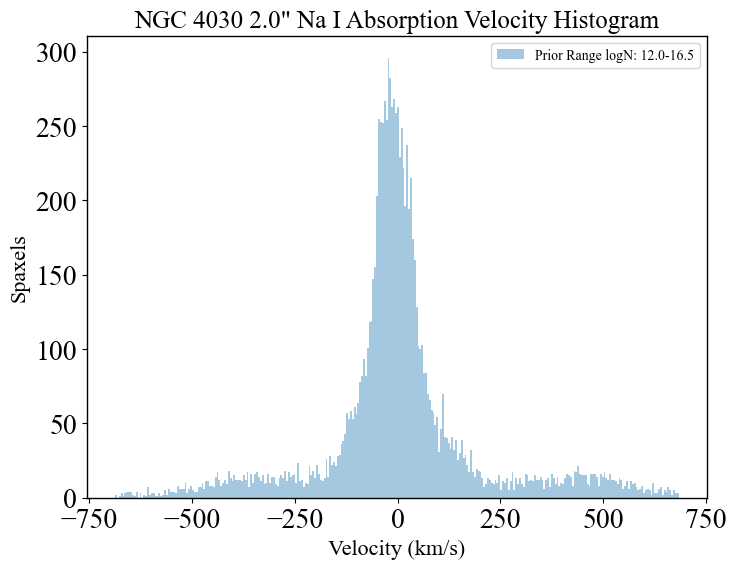

In [10]:
#pl.hist(table_prior1['velocities'][table_prior1['velocities'] > -999],bins=100,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.hist(table_prior2['velocities'][table_prior2['velocities'] > -999],bins=300,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
#pl.hist(table_uniq['velocities'][table_uniq['velocities'] > -999],bins=300,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
#pl.hist(table_prior3['velocities'][table_prior3['velocities'] > -999],bins=300,label ='Prior Range logN: 12.0-20.0',alpha=0.4)
#pl.hist(table_prior4['velocities'][table_prior4['velocities'] > -999],bins=300,label ='Prior Range logN: 12.0-16.5',alpha=0.4)
pl.hist(table_uniq['velocities'][table_uniq['velocities'] > -999],bins=300,label ='Prior Range logN: 12.0-16.5',alpha=0.4)
pl.xlabel('Velocity (km/s)')
pl.ylabel('Spaxels')
pl.title('NGC 4030 2.0" Na I Absorption Velocity Histogram')
#pl.ylim(-5,200)
#pl.xlim(-50,50)
pl.legend();

In [11]:
def get_gas_distrib(table_prior):
    gas_v = table_prior['velocities'][table_prior['velocities'] > -999]
    gas_min = np.percentile(gas_v,1)
    gas_max = np.percentile(gas_v,99)
    gas_v_reduc = gas_v[(gas_v >= gas_min) & (gas_v <= gas_max)]
#     print('1% min: {}'.format(gas_min))
#     print('99% max:{}'.format(gas_max))
    return gas_v_reduc

In [8]:
def get_derived_vals(table, binid):
    binid_indx = np.where(table['bin']== binid)
    percentiles = table['percentiles'][binid_indx][0][:,0]

    lambda_r = percentiles[0]
    N = percentiles[1]
    b_d = percentiles[2]
    C_f = percentiles[3]
    
    return lambda_r, N,b_d,C_f

# get the 99.7% or 0.3% percentile (3sigma) of a specific velocity

# def get_3sig(table,binid):
    
#     lamrest = 5897.558 # in angstroms
#     ndim = 4
#     burnin = 1000
    
#     binid_indx = np.where(table['bin']== binid)
#     sampler = table['samples'][binid_indx][0]
#     samples = sampler[:, burnin:, :].reshape((-1, ndim))
#     # get samples from lambda pdf
#     lambda_samp = samples[:,0]
    
#     # get 3 sigma value in velocity (km/s)
#     if table['velocities'][binid_indx][0] < 0: 
#         per99 = np.percentile(lambda_samp,  99.7, axis=0)
#         vel_3sig99 = c* ((per99/ lamrest) - 1)
#         return vel_3sig99

#     if table['velocities'][binid_indx][0] > 0: 
#         per03 = np.percentile(lambda_samp,  0.3, axis=0)
#         vel_3sig03 = c* ((per03/ lamrest) - 1)
#         return vel_3sig03
    
#     else:
#         return 0

def get_sn(index,spec_filt,espec_filt):
    # get signal to noise ratio for Na I
    return np.median(spec_filt[:,index][:,0]/espec_filt[:,index][:,0]) 

# connect cube values to each bin ID and compile it all together
def get_all_values(table,flux,error):
    # speed of light in km/s
    c = 2.998e5
    # Na I doublet vacuum absorption wavelengths 
    D1 = 5891.582 # in angstroms
    D2 = 5897.558 # in angstroms
    
    # Na I wavelength range
    wv_lim = [5880.0,5910.0]
    spec_filt = flux[(wave >  wv_lim[0]) & (wave <  wv_lim[1]),:,:]
    espec_filt = error[(wave >  wv_lim[0]) & (wave <  wv_lim[1]),:,:]

    bin_id = []
    halpha = []
    gas_velocity = []
    gas_84th = []
    gas_16th = []
    stellar_velocity = []
    stellar_error = []
    stellar_sigma_error = []
    logSFR = []
    snr_bin = []
    lambda_red =[]
    logN = []
    b_ds = []
    C_fs = []
    
    # Na I wavelength range
    wv_lim = [5880.0,5910.0]
    spec_filt = flux[(wave >  wv_lim[0]) & (wave <  wv_lim[1]),:,:]
    espec_filt = error[(wave >  wv_lim[0]) & (wave <  wv_lim[1]),:,:]

    for binid in table['bin']:
        index = binid_map == binid
        binid_indx = np.where(table['bin']== binid)
        bin_id.append(binid)
        halpha.append(halpha_map_corrected[index][0])
        logSFR.append(logSFR_map[index][0])
        gas_velocity.append(table['velocities'][binid_indx][0])
        gas_84th.append(table['vel_uncert_84th_percent'][binid_indx][0])
        gas_16th.append(table['vel_uncert_16th_percent'][binid_indx][0])
        stellar_velocity.append(stellar_vel[index][0])
        stellar_error.append(stell_err[index][0])
        stellar_sigma_error.append(stell_sig_err[index][0])
        snr_bin.append( get_sn(index,spec_filt,espec_filt) )
        
        lamb_r, c_density,b_d,C_f = get_derived_vals(table, binid)
        #sig3_vel = get_3sig(table,binid)
        lambda_red.append(lamb_r)
        logN.append(c_density)
        #sigma3_vel.append(sig3_vel)
        b_ds.append(b_d)
        C_fs.append(C_f)
        
    
    table_allvals = Table([bin_id,halpha, logSFR,gas_velocity,gas_84th,gas_16th,
                           stellar_velocity,stellar_error,stellar_sigma_error,snr_bin,lambda_red,
                           logN,b_ds,C_fs], 
              names=('bin_id','halpha', 'logSFR','gas_vel', 'vel_uncert_84th_percent',
                     'vel_uncert_16th_percent','stellar_vel','stellar_error','stellar_sigma_error',
                     'snr_bin','lambda_red',
                     'logN','b_d','C_f'))
    
    return table_allvals

In [84]:
t_all_pr3['gas_vel'][t_all_pr3['gas_vel']==-999].size

55

In [12]:
# create astropy table containing velocities,SFR,stellar velocities etc.
t_all_pr3 = get_all_values(table_uniq,flux,error)
t_all_pr3 = t_all_pr3[t_all_pr3['gas_vel']>-999]
# filter out high velocities (most likely unrealistic)
t_all_filt = t_all_pr3[(t_all_pr3['gas_vel'] > -400) & (t_all_pr3['gas_vel'] < 400)]

# filter out velocities with high uncertainty widths
# velocity uncertainty widths are created from the difference in the 84th and 16th percentiles 
# in the lambda probability density function
vel_widths = np.absolute(t_all_filt['vel_uncert_84th_percent']-t_all_filt['vel_uncert_16th_percent'])
t_all_good = t_all_filt[vel_widths<100]

In [24]:
t_all_good['gas_vel'][t_all_good['snr_bin'] <10].size#/t_all_good['gas_vel'].size

18

In [43]:
print('Model Absorption Values')
print('Least S.C absorption logN (bind id 265) = {:.2f}'.format(t_all_pr2[t_all_pr2['bin_id']==265]['C_f'][0]))
print('Modest S.C absorption logN (bind id 406) = {:.2f}'.format(t_all_pr2[t_all_pr2['bin_id']==406]['C_f'][0]))
print('Greatest S.C absorption logN (bind id 792) = {:.2f}'.format(t_all_pr2[t_all_pr2['bin_id']==792]['C_f'][0]))

Model Absorption Values
Least S.C absorption logN (bind id 265) = 0.24
Modest S.C absorption logN (bind id 406) = 0.23
Greatest S.C absorption logN (bind id 792) = 0.34


In [87]:
def get_info(bin_ids=None,spaxel_locx=None,spaxel_locy=None):
    if bin_ids.any() != None:
        print('Total bins: {}'.format(len(bin_ids)))
        for bin_ in bin_ids:
            bin_id = np.where(binid_map == bin_)
            print('Spaxel: ['+str(bin_id[1][0])+','+str(bin_id[0][0])+'] '+'Bin ID: ' + str(bin_) )
    if ((spaxel_locx != None) & (spaxel_locy != None)):
        print(binid_map[spaxel_locx,spaxel_locy])

In [13]:
(t_all_pr3['snr_bin'][t_all_pr3['snr_bin']<10].size/t_all_pr3['snr_bin'].size)

0.0330829756795422

In [15]:
t_all_pr3['stellar_error'][(t_all_pr3['stellar_error']<10) & (t_all_pr3['snr_bin']>10)].size/ \
t_all_pr3['stellar_error'].size

0.9421494992846924

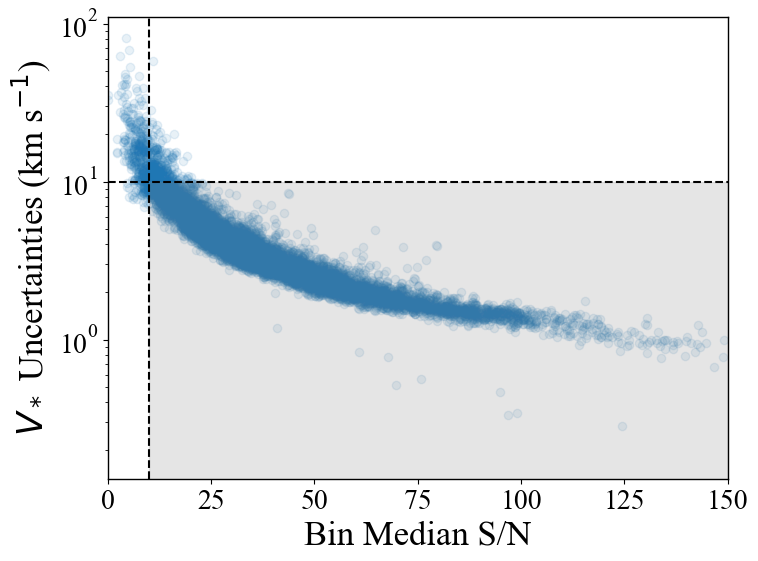

In [19]:
#t_all_filt['stellar_error']
#t_all_filt['stellar_sigma_error']

#t_all_filt['snr_bin']
pl.scatter(t_all_pr3['snr_bin'],t_all_pr3['stellar_error'],alpha = 0.1)
pl.ylabel(r'$V_*$ Uncertainties (km s$^{-1}$)',fontsize=25)
pl.axhline(10,c='k',ls='--')
pl.axvline(10,c='k',ls='--')
pl.xlabel('Bin Median S/N',fontsize=25)
pl.xlim(0,150)
#pl.ylim(-3,90)
pl.yscale('log')
x_range = np.arange(10,150+10,10)
pl.fill_between(x_range,-10,10,color='grey',alpha=0.2);

In [16]:
t_all_pr3['stellar_sigma_error'][(t_all_pr3['stellar_sigma_error']<10) & (t_all_pr3['snr_bin']>10)].size/ \
t_all_pr3['stellar_sigma_error'].size

0.8900214592274678

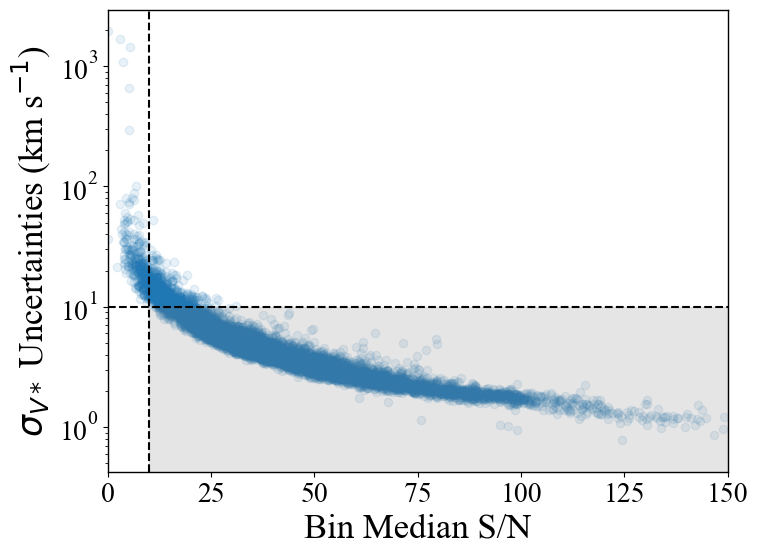

In [18]:
#t_all_filt['stellar_error']
#t_all_filt['stellar_sigma_error']

#t_all_filt['snr_bin']
pl.scatter(t_all_filt['snr_bin'],t_all_filt['stellar_sigma_error'],alpha = 0.1)
pl.ylabel(r'$\sigma_{V*}$ Uncertainties (km s$^{-1}$)',fontsize=25)
pl.axhline(10,c='k',ls='--')
pl.axvline(10,c='k',ls='--')
pl.xlabel('Bin Median S/N',fontsize=25)
#pl.ylim(-3,90)
pl.xlim(0,150)
pl.yscale('log')
x_range = np.arange(10,150+10,10)
pl.fill_between(x_range,-10,10,color='grey',alpha=0.2);

In [68]:
get_info(bin_ids=None,spaxel_locx=32,spaxel_locy=103)
table_good_vals = t_all_pr3[sig3_greater3]
bins_prior3 = table_good_vals['bin_id'][table_good_vals['logN'] < 13]
get_info(bin_ids=bins_prior3)

363


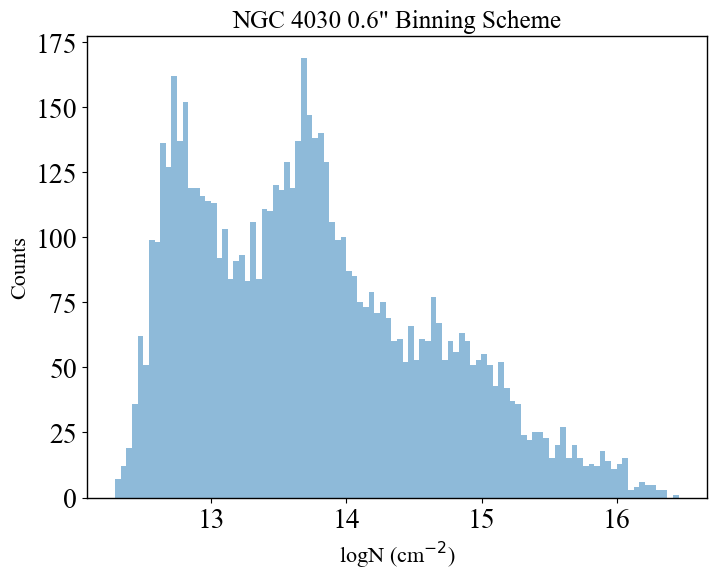

In [9]:
pl.title(r'NGC 4030 0.6" Binning Scheme')
pl.hist(t_all_good['logN'],bins=100,alpha=0.5)

pl.xlabel(r'logN (cm$^{-2}$)')
pl.ylabel('Counts');

In [29]:
np.median(t_all_pr3['snr_bin'])

34.800392

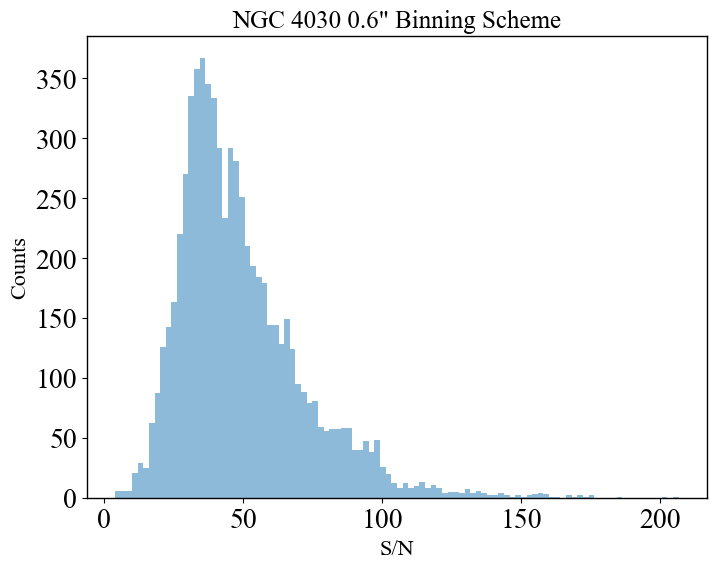

In [26]:
pl.title(r'NGC 4030 0.6" Binning Scheme')
pl.hist(t_all_good['snr_bin'],bins=100,alpha=0.5)

pl.xlabel(r'S/N')
pl.ylabel('Counts');

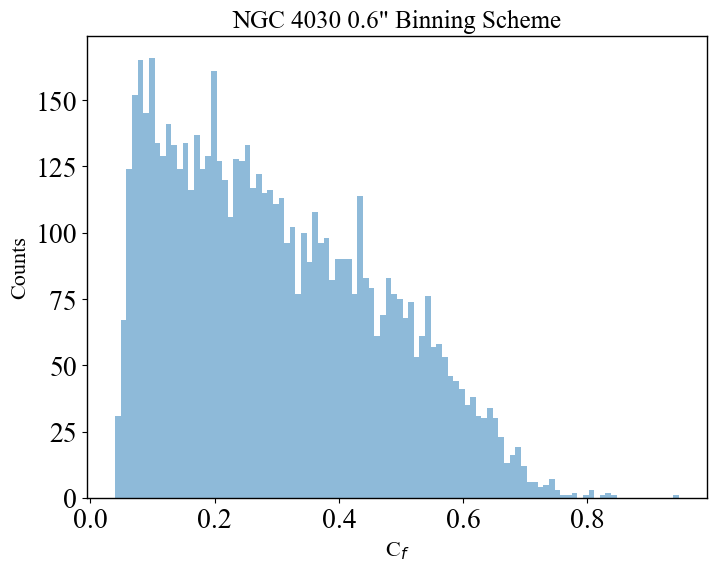

In [11]:
pl.title(r'NGC 4030 0.6" Binning Scheme')
pl.hist(t_all_good['C_f'],bins=100,alpha=0.5)

pl.xlabel(r'C$_f$')
pl.ylabel('Counts');

In [25]:
bad_pos_vel_t

bin_id,halpha,logSFR,gas_vel,vel_uncert_84th_percent,vel_uncert_16th_percent,stellar_vel,lambda_red,logN,b_d,C_f
int32,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1330,25.405190580814093,-3.8332136568314183,650.5147801550451,681.5547869342571,593.5942713263952,91.4907,5910.354793498576,13.464165454317389,64.13239909831087,0.15897708241228392
1879,4.538919986754667,-4.581183587058732,412.6905371866438,443.9628722150246,358.8371712788741,122.33203,5905.6764002681075,12.515971884831334,33.79374447746858,0.2980634236481856
2073,2.9387161387308653,-4.7699784759979735,459.13578449643313,489.1272450839045,416.99210102460404,87.66458,5906.590054519202,14.195796036593542,64.38533677071993,0.08154095706550776
2110,2.3844560867480222,-4.8607467853401545,438.08785323534204,470.00292055002564,374.3659678834899,120.24554,5906.17600716264,13.49907069790954,12.500201451027785,0.27191553656266565
2277,0.6630509945414478,-5.416589183202113,678.1742398975549,692.78953932706,653.0499715220033,129.33563,5910.898900472713,13.400703606170804,34.9294878725227,0.37896984090962005
2311,1.900077873595545,-4.959364713388183,434.2666954073974,460.13962255680576,410.77250142988566,126.85539,5906.100838716012,13.475121380789341,14.944618334515773,0.2350585384990836
2726,0.716994873361244,-5.382620063617182,422.5199715362682,458.82318932976125,364.03125229686026,75.10006,5905.869761376069,12.919777869019182,45.100610121515246,0.47489492563383695
2845,1.9610349601301809,-4.945650777941751,545.1418323581487,571.6994011900127,516.1812952023154,114.48448,5908.281934653344,13.466553775045654,28.535620431611875,0.4401135133149764
2907,7.12888136861986,-4.3851147263155354,404.2685942746728,440.97702636756304,381.5950105117339,-90.593,5905.5107268270185,13.694217647179965,30.912061028653973,0.1675615560025163


In [108]:
bad_pos_vel_t = pos_t_all[(pos_t_all['gas_vel']>150)&(pos_t_all['gas_vel']<200)]
get_info(bin_ids=bad_pos_vel_t['bin_id'])

Total bins: 82
Spaxel: [6,234] Bin ID: 2737
Spaxel: [157,96] Bin ID: 2948
Spaxel: [154,99] Bin ID: 2999
Spaxel: [154,96] Bin ID: 3000
Spaxel: [154,54] Bin ID: 3014
Spaxel: [142,87] Bin ID: 3209
Spaxel: [112,102] Bin ID: 3724
Spaxel: [112,93] Bin ID: 3727
Spaxel: [112,78] Bin ID: 3732
Spaxel: [106,75] Bin ID: 3837
Spaxel: [106,18] Bin ID: 3856
Spaxel: [103,63] Bin ID: 3893
Spaxel: [103,42] Bin ID: 3900
Spaxel: [100,57] Bin ID: 3947
Spaxel: [97,63] Bin ID: 3997
Spaxel: [97,57] Bin ID: 3999
Spaxel: [91,63] Bin ID: 4101
Spaxel: [88,60] Bin ID: 4154
Spaxel: [88,48] Bin ID: 4158
Spaxel: [88,45] Bin ID: 4159
Spaxel: [85,105] Bin ID: 4192
Spaxel: [85,57] Bin ID: 4208
Spaxel: [85,48] Bin ID: 4211
Spaxel: [85,45] Bin ID: 4212
Spaxel: [82,84] Bin ID: 4251
Spaxel: [82,75] Bin ID: 4254
Spaxel: [82,72] Bin ID: 4255
Spaxel: [82,54] Bin ID: 4261
Spaxel: [82,51] Bin ID: 4262
Spaxel: [82,48] Bin ID: 4263
Spaxel: [82,39] Bin ID: 4266
Spaxel: [82,18] Bin ID: 4273
Spaxel: [82,12] Bin ID: 4275
Spaxel: [79,1

In [109]:
bad_neg_vel_t = neg_t_all[(neg_t_all['gas_vel']<-150)&(neg_t_all['gas_vel']>-200)]
get_info(bin_ids=bad_neg_vel_t['bin_id'])

Total bins: 36
Spaxel: [150,318] Bin ID: 209
Spaxel: [141,198] Bin ID: 328
Spaxel: [132,192] Bin ID: 485
Spaxel: [132,198] Bin ID: 487
Spaxel: [108,300] Bin ID: 945
Spaxel: [96,168] Bin ID: 1113
Spaxel: [96,267] Bin ID: 1146
Spaxel: [93,165] Bin ID: 1165
Spaxel: [87,171] Bin ID: 1273
Spaxel: [84,165] Bin ID: 1324
Spaxel: [84,312] Bin ID: 1373
Spaxel: [72,264] Bin ID: 1569
Spaxel: [66,183] Bin ID: 1648
Spaxel: [57,237] Bin ID: 1825
Spaxel: [57,240] Bin ID: 1826
Spaxel: [54,213] Bin ID: 1870
Spaxel: [42,228] Bin ID: 2087
Spaxel: [39,273] Bin ID: 2156
Spaxel: [27,237] Bin ID: 2360
Spaxel: [24,240] Bin ID: 2415
Spaxel: [21,300] Bin ID: 2489
Spaxel: [18,174] Bin ID: 2501
Spaxel: [154,153] Bin ID: 2981
Spaxel: [145,90] Bin ID: 3157
Spaxel: [124,66] Bin ID: 3528
Spaxel: [118,126] Bin ID: 3612
Spaxel: [100,123] Bin ID: 3925
Spaxel: [94,54] Bin ID: 4052
Spaxel: [91,141] Bin ID: 4075
Spaxel: [91,138] Bin ID: 4076
Spaxel: [88,117] Bin ID: 4135
Spaxel: [55,45] Bin ID: 4738
Spaxel: [37,39] Bin ID: 

In [111]:
# seperate positive and negative velocities
pos_t_all = t_all_good[t_all_good['gas_vel'] > 0]
neg_t_all = t_all_good[t_all_good['gas_vel'] < 0]

# upper and lower uncertainties for both negative and positive velocities
pos_upper = np.absolute(pos_t_all['vel_uncert_84th_percent']-pos_t_all['gas_vel'])
pos_lower = np.absolute(pos_t_all['gas_vel']-pos_t_all['vel_uncert_16th_percent'])
pos_yerr = [pos_lower,pos_upper]

neg_upper = np.absolute(neg_t_all['vel_uncert_84th_percent']-neg_t_all['gas_vel'])
neg_lower = np.absolute(neg_t_all['gas_vel']-neg_t_all['vel_uncert_16th_percent'])
neg_yerr = [neg_lower,neg_upper]

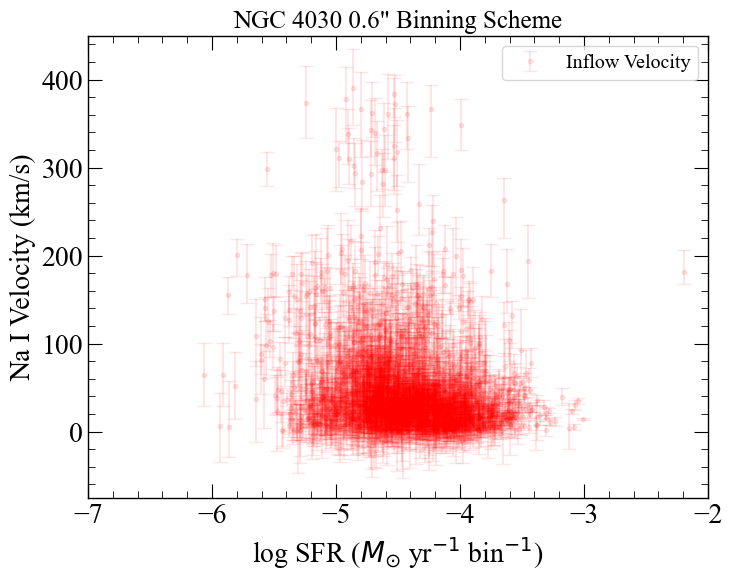

In [114]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
ax.errorbar(pos_t_all['logSFR'],pos_t_all['gas_vel'],
            yerr=pos_yerr,
            fmt=".",
            capsize=5,
           label =r'Inflow Velocity', alpha = 0.1,c='red')

# ax.errorbar(neg_t_all['logSFR'],neg_t_all['gas_vel'],
#             yerr=neg_yerr,
#             fmt=".",
#             capsize=5,
#            label =r'Outflow Velocity ', alpha = 0.1)
ax.set_xlim(-7,-2)
ax.set_ylim(-75,450)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'log SFR ($M_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='x-large');#,frameon=False);
#pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr.pdf',bbox_inches='tight');

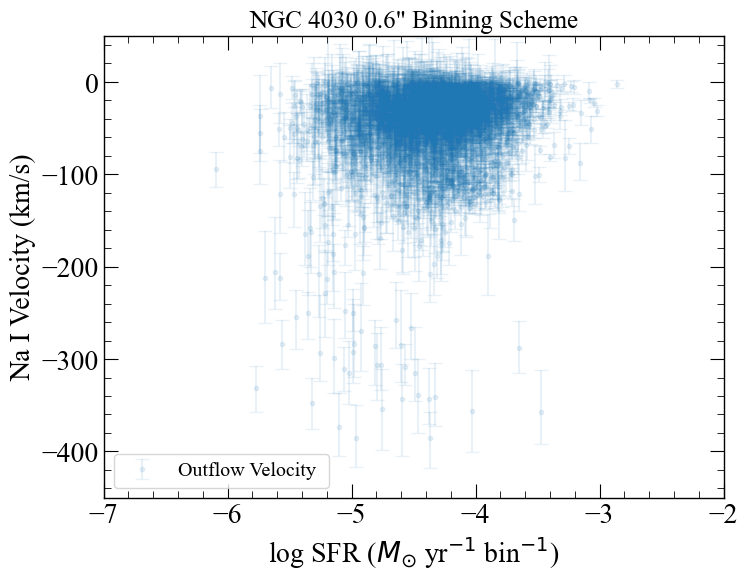

In [116]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
# ax.scatter(pos_t_all['logSFR'],pos_t_all['gas_vel'],
#             #yerr=pos_yerr,
#             marker=".",
#             #capsize=5,
#            label =r'Inflow Velocity', alpha = 0.1,c='red')

ax.errorbar(neg_t_all['logSFR'],neg_t_all['gas_vel'],
            yerr=neg_yerr,
            fmt=".",
            capsize=5,
           label =r'Outflow Velocity ', alpha = 0.1)
ax.set_xlim(-7,-2)
ax.set_ylim(-450,50)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'log SFR ($M_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='x-large');#,frameon=False);
#pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr.pdf',bbox_inches='tight');

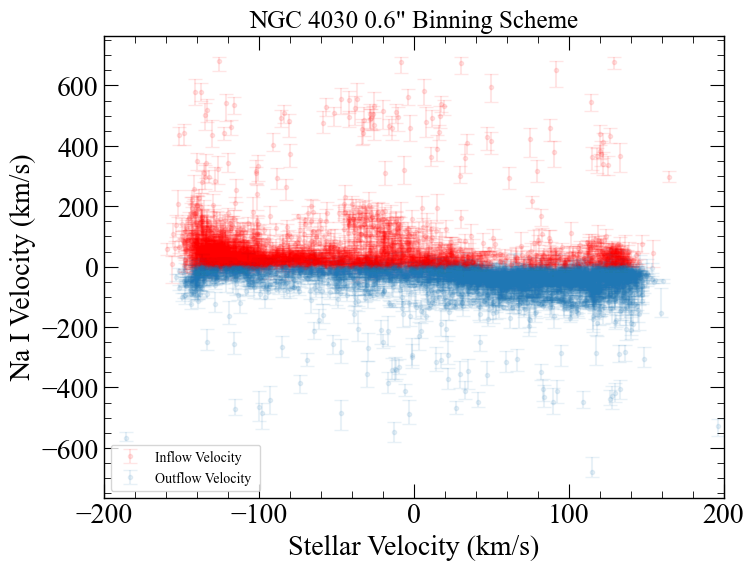

In [13]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
ax.errorbar(pos_t_all['stellar_vel'],pos_t_all['gas_vel'],
            yerr=pos_yerr,
            fmt=".",
            capsize=5,
           label =r'Inflow Velocity', alpha = 0.1,c='red')

ax.errorbar(neg_t_all['stellar_vel'],neg_t_all['gas_vel'],
            yerr=neg_yerr,
            fmt=".",
            capsize=5,
           label =r'Outflow Velocity ', alpha = 0.1)
ax.set_xlim(-200,200)
# ax.set_ylim(-500,50)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'Stellar Velocity (km/s)',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='medium');#,frameon=False);
#pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr.pdf',bbox_inches='tight');

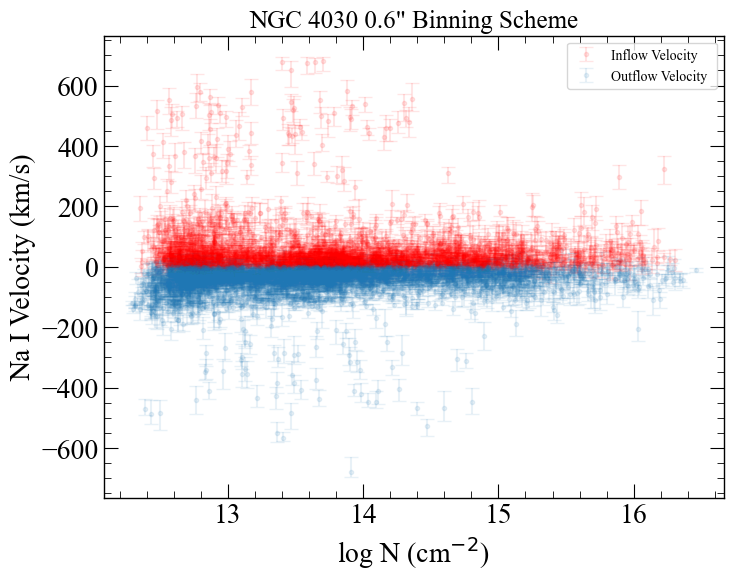

In [32]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
ax.errorbar(pos_t_all['logN'],pos_t_all['gas_vel'],
            yerr=pos_yerr,
            fmt=".",
            capsize=5,
           label =r'Inflow Velocity', alpha = 0.1,c='red')

ax.errorbar(neg_t_all['logN'],neg_t_all['gas_vel'],
            yerr=neg_yerr,
            fmt=".",
            capsize=5,
           label =r'Outflow Velocity ', alpha = 0.1)
#ax.set_xlim(-200,200)
# ax.set_ylim(-500,50)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'log N (cm$^{-2}$)',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='medium');#,frameon=False);

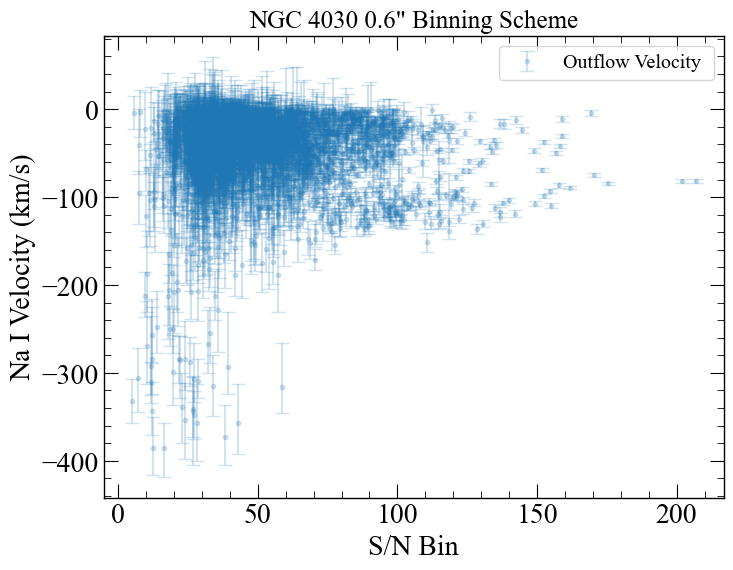

In [126]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
# ax.errorbar(pos_t_all['snr_bin'],pos_t_all['gas_vel'],
#             yerr=pos_yerr,
#             fmt=".",
#             capsize=5,
#            label =r'Inflow Velocity', alpha = 0.1,c='red')

ax.errorbar(neg_t_all['snr_bin'],neg_t_all['gas_vel'],
            yerr=neg_yerr,
            fmt=".",
            capsize=5,
           label =r'Outflow Velocity ', alpha = 0.2)
#ax.set_xlim(-200,200)
# ax.set_ylim(-500,50)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'S/N Bin',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='x-large');#,frameon=False);

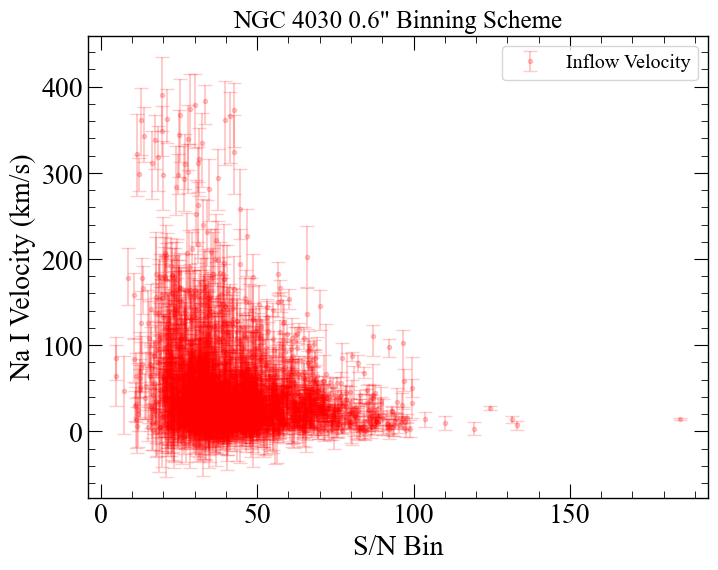

In [127]:
fig, ax = pl.subplots()
ax.set_title('NGC 4030 0.6" Binning Scheme')
ax.errorbar(pos_t_all['snr_bin'],pos_t_all['gas_vel'],
            yerr=pos_yerr,
            fmt=".",
            capsize=5,
           label =r'Inflow Velocity', alpha = 0.2,c='red')

# ax.errorbar(neg_t_all['snr_bin'],neg_t_all['gas_vel'],
#             yerr=neg_yerr,
#             fmt=".",
#             capsize=5,
#            label =r'Outflow Velocity ', alpha = 0.1)
#ax.set_xlim(-200,200)
# ax.set_ylim(-500,50)

#ax = pl.axes()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major',direction='in',bottom=True, top=True, left=True, right=True,
                    length=10)
ax.tick_params(which = 'minor',direction='in',bottom=True, top=True, left=True, right=True,
                    length=5)
                
pl.xlabel(r'S/N Bin',fontsize=20)
pl.ylabel(r'Na I Velocity (km/s)',fontsize=20)
pl.legend(fontsize='x-large');#,frameon=False);

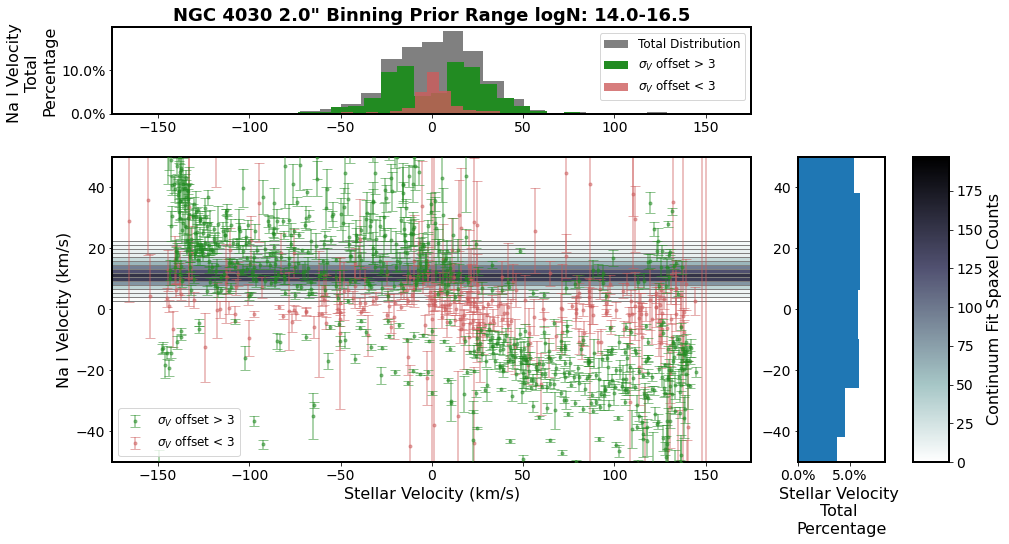

In [104]:
N, bins = np.histogram(gas_v_reduc2, bins=15)
#N, bins = np.histogram(gas_v_reduc3, bins=15)
cmap = cm.get_cmap('bone_r')

# fig, (ax, cax) = pl.subplots(1,2, figsize=(15,8),
#                              gridspec_kw={'width_ratios': [1, 0.05]})
fig, ax = pl.subplots(1,1, figsize=(15,8))

ax.errorbar(stellar_velocity_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ offset > 3',
            alpha = 0.5,zorder=3,color='forestgreen')
ax.errorbar(stellar_velocity_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ offset < 3',
            alpha = 0.5,zorder=2,color='indianred')
# ax.errorbar(stellar_velocity_prior3[sig3_greater3],gas_velocity_prior3[sig3_greater3],
#             yerr=sigma_vel_prior3[sig3_greater3],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
#             alpha = 0.5,zorder=3,color='forestgreen')
# ax.errorbar(stellar_velocity_prior3[sig3_less3],gas_velocity_prior3[sig3_less3],
#             yerr=sigma_vel_prior3[sig3_less3],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
#             alpha = 0.5,zorder=2,color='indianred')

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_hist_top = divider.append_axes("top", 1.2, pad=0.6,sharex=ax)
ax_hist_side = divider.append_axes("right", 1.2, pad=0.65, sharey=ax)
ax_cb = divider.append_axes('right',0.5,pad=0.4)
ax_hist_top.set_title(r'NGC 4030 2.0" Binning Prior Range logN: 14.0-16.5')

# histogram for total velocity distribution
ax_hist_top.hist(gas_velocity_prior2,bins=100,color = 'gray',
                 label='Total Distribution',
                 weights=np.ones(len(gas_velocity_prior2)) / len(gas_velocity_prior2))

# histogram for (good) velocities that have a sigma uncertainty greater than 3 
ax_hist_top.hist(gas_velocity_prior2[sig3_greater2],bins=100,
                 color='forestgreen',label=r'$\sigma_V$ offset > 3',
                weights=np.ones(len(gas_velocity_prior2[sig3_greater2])) / len(gas_velocity_prior2))
# histogram for (bad) velocities that have a sigma uncertainty less than 3 
ax_hist_top.hist(gas_velocity_prior2[sig3_less2],bins=100,alpha=0.8,
                 color='indianred',label=r'$\sigma_V$ offset < 3',
                weights=np.ones(len(gas_velocity_prior2[sig3_less2])) / len(gas_velocity_prior2))
ax_hist_top.yaxis.set_major_formatter(PercentFormatter(1))

# stellar velocity histogram
ax_hist_side.hist(stellar_velocity_prior2,bins=100, orientation='horizontal',
                 weights=np.ones(len(stellar_velocity_prior2)) / len(stellar_velocity_prior2))
ax_hist_side.xaxis.set_major_formatter(PercentFormatter(1))

#ax_hist_top.set_xlim(-100,100)
#ax_hist_top.set_ylim(-5,225)
ax_hist_top.set_ylabel('Na I Velocity \nTotal \nPercentage')
ax_hist_side.set_xlabel('Stellar Velocity \nTotal \nPercentage')
#ax_hist_top.set_xlabel('Na I Velocity (km/s)')
ax_hist_top.legend(fontsize='large')

for i in range(bins.size-1):
    color = cmap(N[i])
    ax.axhspan(bins[i],bins[i+1], facecolor=color,edgecolor='0.5',zorder=1)
matplotlib.colorbar.ColorbarBase(ax_cb, orientation='vertical', 
                               cmap=cm.bone_r,
                               norm=matplotlib.colors.Normalize(0, N.max()),  # vmax and vmin
                               label='Continuum Fit Spaxel Counts')
    

ax.set_ylim(-50,50)
ax.set_xlabel(r'Stellar Velocity (km/s)')
ax.set_ylabel(r'Na I Velocity (km/s)')
ax.set_xlim(-175,175)
ax.legend(fontsize='large');

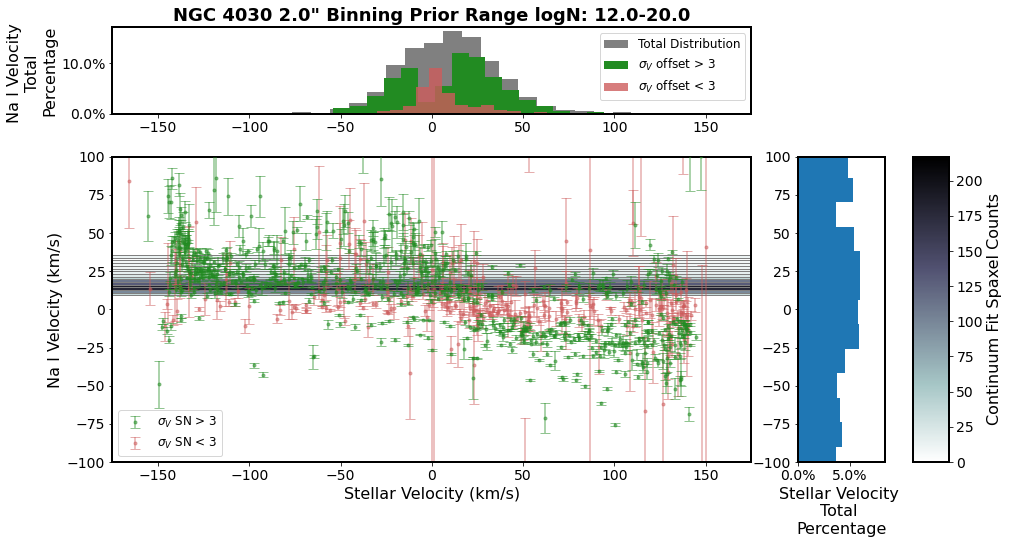

In [105]:
#N, bins = np.histogram(gas_v_reduc2, bins=15)
N, bins = np.histogram(gas_v_reduc3, bins=15)
cmap = cm.get_cmap('bone_r')

# fig, (ax, cax) = pl.subplots(1,2, figsize=(15,8),
#                              gridspec_kw={'width_ratios': [1, 0.05]})
fig, ax = pl.subplots(1,1, figsize=(15,8))

# ax.errorbar(stellar_velocity_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
#             yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ offset > 3',
#             alpha = 0.5,zorder=3,color='forestgreen')
# ax.errorbar(stellar_velocity_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
#             yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ offset < 3',
#             alpha = 0.5,zorder=2,color='indianred')
ax.errorbar(stellar_velocity_prior3[sig3_greater3],gas_velocity_prior3[sig3_greater3],
            yerr=sigma_vel_prior3[sig3_greater3],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5,zorder=3,color='forestgreen')
ax.errorbar(stellar_velocity_prior3[sig3_less3],gas_velocity_prior3[sig3_less3],
            yerr=sigma_vel_prior3[sig3_less3],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5,zorder=2,color='indianred')

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_hist_top = divider.append_axes("top", 1.2, pad=0.6,sharex=ax)
ax_hist_side = divider.append_axes("right", 1.2, pad=0.65, sharey=ax)
ax_cb = divider.append_axes('right',0.5,pad=0.4)
ax_hist_top.set_title(r'NGC 4030 2.0" Binning Prior Range logN: 12.0-20.0')

# histogram for total velocity distribution
ax_hist_top.hist(gas_velocity_prior3,bins=100,color = 'gray',
                 label='Total Distribution',
                 weights=np.ones(len(gas_velocity_prior3)) / len(gas_velocity_prior3))

# histogram for (good) velocities that have a sigma uncertainty greater than 3 
ax_hist_top.hist(gas_velocity_prior3[sig3_greater3],bins=100,
                 color='forestgreen',label=r'$\sigma_V$ offset > 3',
                weights=np.ones(len(gas_velocity_prior3[sig3_greater3])) / len(gas_velocity_prior3))
# histogram for (bad) velocities that have a sigma uncertainty less than 3 
ax_hist_top.hist(gas_velocity_prior3[sig3_less3],bins=100,alpha=0.8,
                 color='indianred',label=r'$\sigma_V$ offset < 3',
                weights=np.ones(len(gas_velocity_prior3[sig3_less3])) / len(gas_velocity_prior3))
ax_hist_top.yaxis.set_major_formatter(PercentFormatter(1))

# stellar velocity histogram
ax_hist_side.hist(stellar_velocity_prior3,bins=100, orientation='horizontal',
                 weights=np.ones(len(stellar_velocity_prior3)) / len(stellar_velocity_prior3))
ax_hist_side.xaxis.set_major_formatter(PercentFormatter(1))

#ax_hist_top.set_xlim(-100,100)
#ax_hist_top.set_ylim(-5,225)
ax_hist_top.set_ylabel('Na I Velocity \nTotal \nPercentage')
ax_hist_side.set_xlabel('Stellar Velocity \nTotal \nPercentage')
#ax_hist_top.set_xlabel('Na I Velocity (km/s)')
ax_hist_top.legend(fontsize='large')

for i in range(bins.size-1):
    color = cmap(N[i])
    ax.axhspan(bins[i],bins[i+1], facecolor=color,edgecolor='0.5',zorder=1)
matplotlib.colorbar.ColorbarBase(ax_cb, orientation='vertical', 
                               cmap=cm.bone_r,
                               norm=matplotlib.colors.Normalize(0, N.max()),  # vmax and vmin
                               label='Continuum Fit Spaxel Counts')
    

ax.set_ylim(-100,100)
ax.set_xlabel(r'Stellar Velocity (km/s)')
ax.set_ylabel(r'Na I Velocity (km/s)')
ax.set_xlim(-175,175)
ax.legend(fontsize='large');

In [411]:
print('logN: 14-16.5')
print('# of velocities greater than a 3 sigma offset: ',gas_velocity_prior2[sig3_greater2].size)
print('# of velocities less than a 3 sigma offset: ',gas_velocity_prior2[sig3_less2].size)

print('\n')
print('logN: 12-20.0')
print('# of velocities greater than a 3 sigma offset: ',gas_velocity_prior3[sig3_greater3].size)
print('# of velocities less than a 3 sigma offset: ',gas_velocity_prior3[sig3_less3].size)

logN: 14-16.5
# of velocities greater than a 3 sigma offset:  764
# of velocities less than a 3 sigma offset:  284


logN: 12-20.0
# of velocities greater than a 3 sigma offset:  426
# of velocities less than a 3 sigma offset:  622


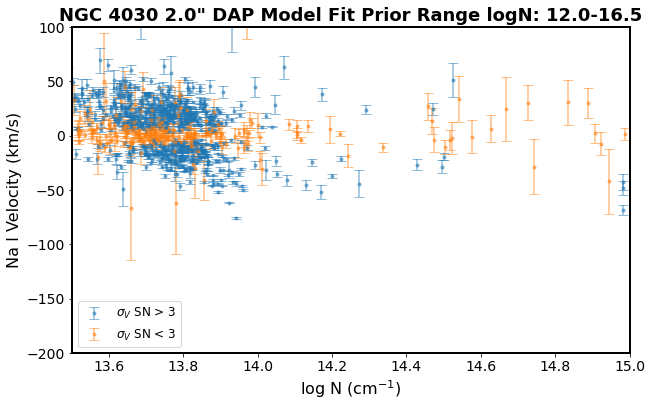

In [11]:
# pl.title(r'NGC 4030 1.0" Prior Range logN: 12.0-20.0')
pl.title(r'NGC 4030 2.0" DAP Model Fit Prior Range logN: 12.0-16.5')
#pl.title(r'NGC 4030 2.0" DAP Model Fit Prior Range logN: 12.0-`6.0')
# pl.errorbar(logN_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
#             yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
#             alpha = 0.5)
# pl.errorbar(logN_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
#             yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
#             alpha = 0.5)

# pl.errorbar(logN_prior3,gas_velocity_prior3,
#             yerr=sigma_vel_prior3,fmt=".",capsize=5,
#             alpha = 0.25)

logN_sig_greater3 = logN_prior3[sig3_greater3]
gas_vel_sig_greater3= gas_velocity_prior3[sig3_greater3]

pl.errorbar(logN_prior3[sig3_greater3],gas_velocity_prior3[sig3_greater3],
            yerr=sigma_vel_prior3[sig3_greater3],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(logN_prior3[sig3_less3],gas_velocity_prior3[sig3_less3],
            yerr=sigma_vel_prior3[sig3_less3],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.xlabel(r'log N (cm$^{-1}$)')
pl.ylabel(r'Na I Velocity (km/s)')
pl.ylim(-200,100)
pl.xlim(13.5,15.0);
pl.legend(fontsize='large');

In [12]:
logN_sig_greater3 = logN_prior3[sig3_greater3]
gas_vel_sig_greater3 = gas_velocity_prior3[sig3_greater3]
bin_id_greater3 = bin_id_prior3[sig3_greater3]
halpha_prior3 = halpha_prior3[sig3_greater3]

logN_gasv_indx = np.where((logN_sig_greater3 > 13.5) & (logN_sig_greater3 < 14.6) &
                     (gas_vel_sig_greater3 > -150) & (gas_vel_sig_greater3 < -25))

gas_vel_filt = gas_vel_sig_greater3[logN_gasv_indx]
logN_filt = logN_sig_greater3[logN_gasv_indx]
bin_id_filt = bin_id_greater3[logN_gasv_indx]
halpha_filt = halpha_prior3[logN_gasv_indx]

In [13]:
gas_vel_filt[gas_vel_filt<-50]

-61.55390206158828
-51.94844389887046
-75.47574251186934
-51.86606753377958
-50.37115929835059


In [18]:
bin_id_gasvel

3
4
19
143
536


In [17]:
bin_id_gasvel = bin_id_filt[gas_vel_filt<-50]
get_info(bin_ids=bin_id_gasvel,spaxel_locx=None,spaxel_locy=None)

[192,152]
[202,152]
[192,142]
[312,72]
[203,162]


Text(0.5, 0, 'Measured logN (cm-2)')

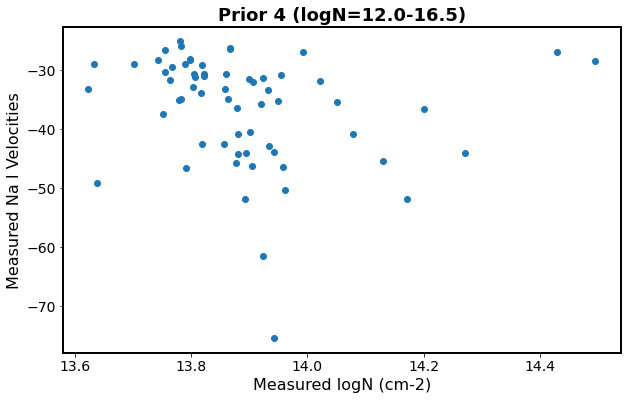

In [23]:
pl.scatter(logN_filt,gas_vel_filt)
pl.title('Prior 4 (logN=12.0-16.5)')
pl.ylabel('Measured Na I Velocities')
pl.xlabel('Measured logN (cm-2)')
#pl.xlim(-20,-80);

Text(0.5, 0, 'Halpha flux (1e-17 ergs/cm^2/s)')

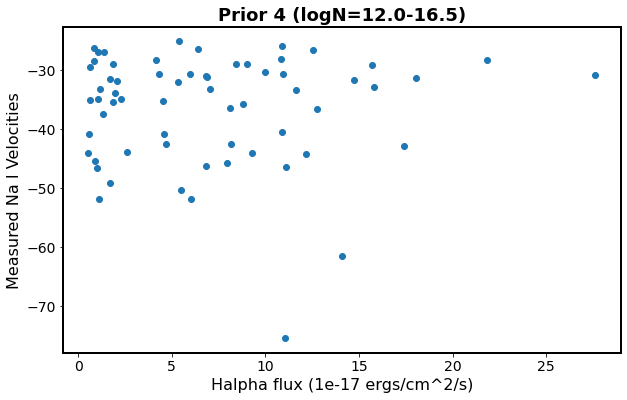

In [21]:
pl.scatter(halpha_filt,gas_vel_filt)
pl.title('Prior 4 (logN=12.0-16.5)')
pl.ylabel('Measured Na I Velocities')
pl.xlabel('Halpha flux (1e-17 ergs/cm^2/s)')
#pl.xlim(-20,-80);

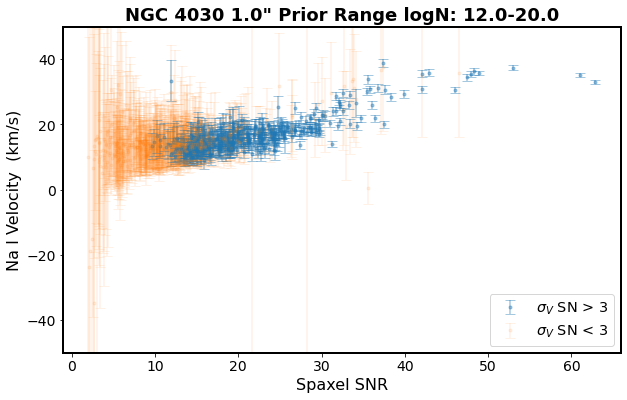

In [20]:
pl.title(r'NGC 4030 1.0" Prior Range logN: 12.0-20.0')
#pl.title(r'NGC 4030 2.0" Prior Range logN: 14.0-16.5')
# pl.errorbar(snr_spxl_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
#             yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
#             alpha = 0.5)
# pl.errorbar(snr_spxl_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
#             yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
#             alpha = 0.5)
pl.errorbar(snr_spxl_prior3[sig3_greater3],gas_velocity_prior3[sig3_greater3],
            yerr=sigma_vel_prior3[sig3_greater3],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.4)
pl.errorbar(snr_spxl_prior3[sig3_less3],gas_velocity_prior3[sig3_less3],
            yerr=sigma_vel_prior3[sig3_less3],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.1)
pl.xlabel('Spaxel SNR')
pl.ylabel(r'Na I Velocity  (km/s)')
pl.ylim(-50,50)
pl.legend(fontsize='x-large');

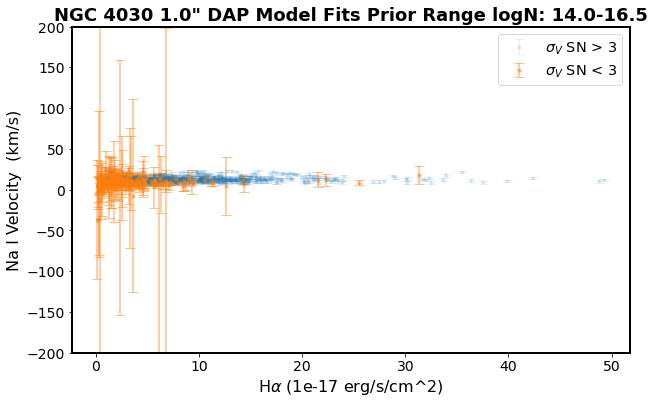

In [140]:
# pl.title(r'NGC 4030 Prior Range logN: 14.0-16.5')
pl.title(r'NGC 4030 1.0" DAP Model Fits Prior Range logN: 14.0-16.5')
# pl.errorbar(halpha_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
#             yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
#             alpha = 0.5)
# pl.errorbar(halpha_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
#             yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
#             alpha = 0.5)
pl.errorbar(halpha_prior3[sig3_greater3],gas_velocity_prior3[sig3_greater3],
            yerr=sigma_vel_prior3[sig3_greater3],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.1)
pl.errorbar(halpha_prior3[sig3_less3],gas_velocity_prior3[sig3_less3],
            yerr=sigma_vel_prior3[sig3_less3],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.ylim(-200,200)
#pl.xlim()
pl.xlabel(r'H$\alpha$ (1e-17 erg/s/cm^2)')
pl.ylabel(r'Na I Velocity  (km/s)')
pl.legend(fontsize='x-large');

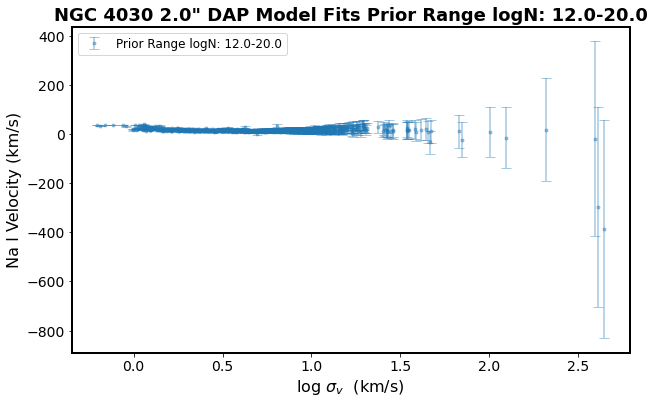

In [35]:
pl.title(r'NGC 4030 2.0" DAP Model Fits Prior Range logN: 12.0-20.0')
pl.errorbar(np.log10(sigma_vel_prior3),gas_velocity_prior3, 
            yerr=sigma_vel_prior3,fmt=".",capsize=5,
            label ='Prior Range logN: 12.0-20.0',alpha=0.4)
pl.ylabel('Na I Velocity (km/s)')
pl.xlabel(r'log $\sigma_{v}$  (km/s)')
pl.legend(fontsize='large');

In [461]:
def get_spxl_std(snr_spaxels,spacing,gas_velocity):
    max_num = round(np.max(snr_spaxels))
    spxl_bins = np.arange(0,max_num+spacing,spacing)
    indices = np.digitize(snr_spaxels,spxl_bins)
    std_gas = []
    
    for i in range(1,np.max(indices)+1):
        indx = np.where(indices == i)
        std = np.std(gas_velocity[indx])
        std_gas.append(std)
    std_gas = np.array(std_gas)
    std_gas[np.isfinite(std_gas) == False] = 0
    return spxl_bins,std_gas

# get the median value for a given bin
def get_median_bin(arr_bin,arr_median,num_bin):
    '''
    PURPOSE:
            Create bins given an input array and calculate the median value per bin
            given another input array

    PARAMETERS:
            arr_bin;    np.array:  array to form bins from
            arr_median; np.array:  array to calculate median value per bin
            num_bin;       float:  number of bins to form 
            
    RETURNS:
            half_bins;  np.array: array containing half-way value between each bin
            median_vals;np.array: array containing median value per bin
    '''
    
    min_num = np.min(arr_bin)
    max_num = np.max(arr_bin)
    
    bins = np.linspace(min_num, max_num, num_bin+1)
    indices = np.digitize(arr_bin, bins)
    
    median_vals = [np.median(arr_median[indices == i]) for i in range(1, len(bins))]
    print([arr_median[indices == i].size for i in range(1, len(bins))])
    std_vals = [np.std(arr_median[indices == i]) for i in range(1, len(bins))]
    
    half_bins = np.zeros(len(bins)-1)
    for i in range(0,len(half_bins)): 
        half_bins[i] = np.mean([bins[i],bins[i+1]])
        
    return half_bins,np.array(median_vals),np.array(std_vals)

In [482]:
t_allsig3more = vstack([pos_t_allsig3more,neg_t_allsig3more])
t_allsig3more['logN']

13.630825966670443
13.793501702071913
13.811493647382637
13.802233065586563
13.699882366902488
13.752144576387373
13.743077752254155
13.801580466705245
13.673148123754217
13.709161380066226
13.683003881901534


[3, 10, 21, 27, 43, 43, 53, 68, 83, 93, 99, 84, 43, 14, 8]
[2, 4, 11, 9, 14, 9, 19, 17, 30, 38, 31, 45, 20, 9, 8]
[3, 9, 16, 16, 32, 29, 38, 46, 55, 54, 61, 35, 22, 5, 4]


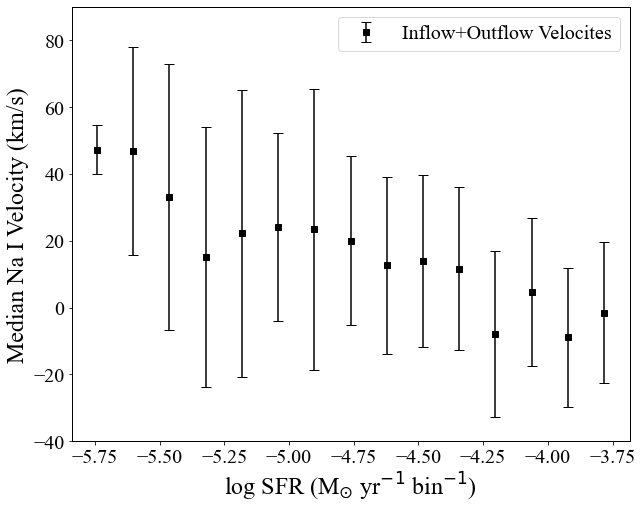

In [489]:
binsize = 15
# SFR_bins_tot, gasvel_medians_tot, gasvel_stds_tot = get_median_bin(t_allsig3more['logSFR'],
#                                                        t_allsig3more['gas_vel'],binsize)
SFR_bins_tot, gasvel_medians_tot, gasvel_stds_tot = get_median_bin(t_allsig3more['logSFR'],
                                                       t_allsig3more['gas_vel'],binsize)

SFR_bins_neg, gasvel_medians_neg, gasvel_stds_neg = get_median_bin(neg_t_allsig3more['logSFR'],
                                                       neg_t_allsig3more['gas_vel'],binsize)

SFR_bins_pos, gasvel_medians_pos, gasvel_stds_pos = get_median_bin(pos_t_allsig3more['logSFR'],
                                                       pos_t_allsig3more['gas_vel'],binsize)

pl.errorbar(SFR_bins_tot,gasvel_medians_tot,yerr=gasvel_stds_tot,capsize=5,
            fmt='s',label='Inflow+Outflow Velocites',c='k')
#pl.errorbar(SFR_bins_neg,gasvel_medians_neg,yerr=gasvel_stds_neg,capsize=5,fmt='s',label='Outflow Velocites')
# pl.errorbar(SFR_bins_pos,gasvel_medians_pos,yerr=gasvel_stds_pos,capsize=5,
#             fmt='s',label='Inflow Velocites',c='r')

pl.ylabel('Median Na I Velocity (km/s)',fontsize=24)
pl.xlabel(r'log SFR (M$_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=24)
pl.ylim(-40,90)
pl.legend(fontsize = 20,frameon=True,loc='upper right')
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr_tot.pdf',bbox_inches='tight');

[3, 10, 21, 27, 43, 43, 53, 68, 83, 93, 99, 84, 43, 14, 8]
[2, 4, 11, 9, 14, 9, 19, 17, 30, 38, 31, 45, 20, 9, 8]
[3, 9, 16, 16, 32, 29, 38, 46, 55, 54, 61, 35, 22, 5, 4]


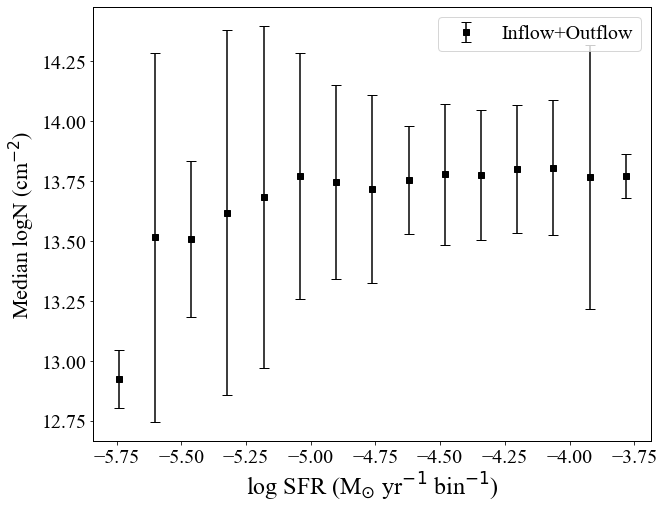

In [486]:
binsize = 15
# SFR_bins_tot, gasvel_medians_tot, gasvel_stds_tot = get_median_bin(t_allsig3more['logSFR'],
#                                                        t_allsig3more['gas_vel'],binsize)
SFR_bins_tot, gasvel_medians_tot, gasvel_stds_tot = get_median_bin(t_allsig3more['logSFR'],
                                                       t_allsig3more['logN'],binsize)

SFR_bins_neg, gasvel_medians_neg, gasvel_stds_neg = get_median_bin(neg_t_allsig3more['logSFR'],
                                                       neg_t_allsig3more['gas_vel'],binsize)

SFR_bins_pos, gasvel_medians_pos, gasvel_stds_pos = get_median_bin(pos_t_allsig3more['logSFR'],
                                                       pos_t_allsig3more['gas_vel'],binsize)

pl.errorbar(SFR_bins_tot,gasvel_medians_tot,yerr=gasvel_stds_tot,capsize=5,
            fmt='s',label='Inflow+Outflow',c='k')
#pl.errorbar(SFR_bins_neg,gasvel_medians_neg,yerr=gasvel_stds_neg,capsize=5,fmt='s',label='Outflow Velocites')
# pl.errorbar(SFR_bins_pos,gasvel_medians_pos,yerr=gasvel_stds_pos,capsize=5,
#             fmt='s',label='Inflow Velocites',c='r')

pl.ylabel('Median logN (cm$^{-2}$)',fontsize=24)
pl.xlabel(r'log SFR (M$_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=24)
#pl.ylim(-40,90)
pl.legend(fontsize = 20,frameon=True,loc='upper right');
#pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr_tot.pdf',bbox_inches='tight');

[2, 4, 11, 9, 14, 9, 19, 17, 30, 38, 31, 45, 20, 9, 8]


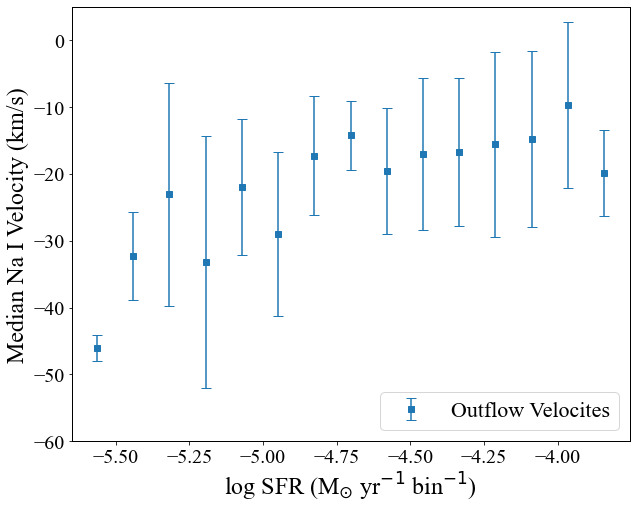

In [479]:
binsize = 15
SFR_bins_neg, gasvel_medians_neg, gasvel_stds_neg = get_median_bin(neg_t_allsig3more['logSFR'],
                                                       neg_t_allsig3more['gas_vel'],binsize)

pl.errorbar(SFR_bins_neg,gasvel_medians_neg,yerr=gasvel_stds_neg,capsize=5,fmt='s',label='Outflow Velocites')
pl.ylabel('Median Na I Velocity (km/s)',fontsize=24)
pl.xlabel(r'log SFR (M$_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=24)
pl.ylim(-60,5)
pl.legend(fontsize = 22,frameon=True,loc='lower right')
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr_outflow.pdf',bbox_inches='tight');

[3, 9, 16, 16, 32, 29, 38, 46, 55, 54, 61, 35, 22, 5, 4]


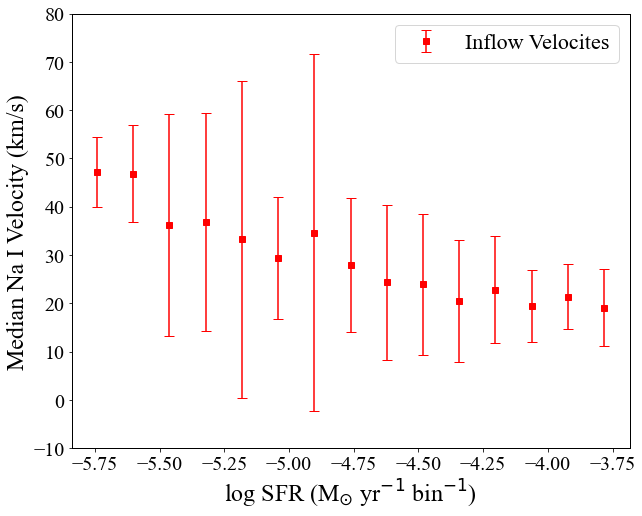

In [478]:
binsize = 15
SFR_bins_pos, gasvel_medians_pos, gasvel_stds_pos = get_median_bin(pos_t_allsig3more['logSFR'],
                                                       pos_t_allsig3more['gas_vel'],binsize)

pl.errorbar(SFR_bins_pos,gasvel_medians_pos,yerr=gasvel_stds_pos,capsize=5,
            fmt='s',label='Inflow Velocites',c='r')
pl.ylabel('Median Na I Velocity (km/s)',fontsize=24)
pl.xlabel(r'log SFR (M$_{\odot}$ yr$^{-1} $ bin$^{-1}$)',fontsize=24)
pl.ylim(-10,80)
pl.legend(fontsize = 22,frameon=True,loc='upper right')
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/vel_vs_sfr_inflow.pdf',bbox_inches='tight');

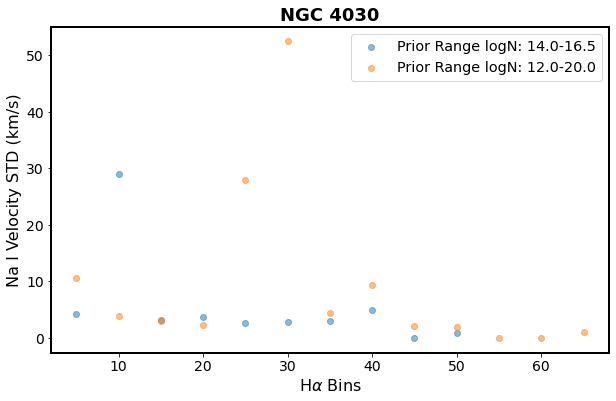

In [34]:
spacing = 5
#spxl_bins_prior1,std_gas_prior1 = get_spxl_std(snr_spxl_prior1,spacing,gas_velocity_prior1)
halpha_bins_prior2,std_gas_prior2 = get_spxl_std(halpha_prior2,spacing,gas_velocity_prior2)
spxl_bins_prior3,std_gas_prior3 = get_spxl_std(snr_spxl_prior3,spacing,gas_velocity_prior3)

#pl.scatter(spxl_bins_prior1[1:],std_gas_prior1,label ='Prior Range logN: 11.4-16.0',alpha = 0.7)
pl.scatter(halpha_bins_prior2[1:],std_gas_prior2,label ='Prior Range logN: 14.0-16.5',alpha = 0.5)
pl.scatter(spxl_bins_prior3[1:],std_gas_prior3,label ='Prior Range logN: 12.0-20.0',alpha = 0.5)
pl.title('NGC 4030')
pl.ylabel('Na I Velocity STD (km/s)')
pl.xlabel(r'H$\alpha$ Bins')
pl.legend(fontsize = 'x-large');

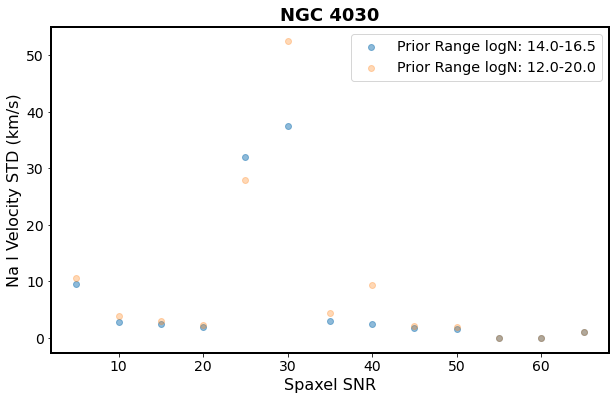

In [33]:
spacing = 5
#spxl_bins_prior1,std_gas_prior1 = get_spxl_std(snr_spxl_prior1,spacing,gas_velocity_prior1)
spxl_bins_prior2,std_gas_prior2 = get_spxl_std(snr_spxl_prior2,spacing,gas_velocity_prior2)
spxl_bins_prior3,std_gas_prior3 = get_spxl_std(snr_spxl_prior3,spacing,gas_velocity_prior3)

#pl.scatter(spxl_bins_prior1[1:],std_gas_prior1,label ='Prior Range logN: 11.4-16.0',alpha = 0.7)
pl.scatter(spxl_bins_prior2[1:],std_gas_prior2,label ='Prior Range logN: 14.0-16.5',alpha = 0.5)
pl.scatter(spxl_bins_prior3[1:],std_gas_prior3,label ='Prior Range logN: 12.0-20.0',alpha = 0.3)
pl.title('NGC 4030')
pl.ylabel('Na I Velocity STD (km/s)')
pl.xlabel('Spaxel SNR')
pl.legend(fontsize = 'x-large');

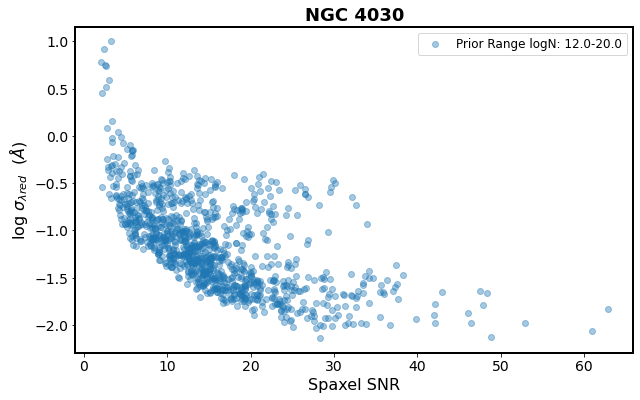

In [258]:
pl.title(r'NGC 4030')
pl.scatter(snr_spxl_prior3,np.log10(sigma_lamb_prior3),label ='Prior Range logN: 12.0-20.0',alpha=0.4)
pl.xlabel('Spaxel SNR')
pl.ylabel(r'log $\sigma_{\lambda red}$  ($\AA$)')
pl.legend(fontsize='large');

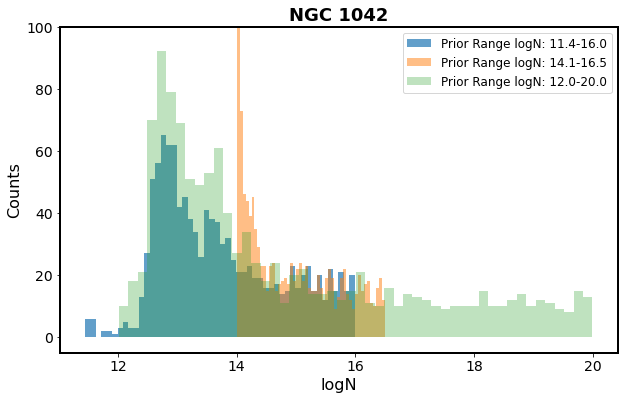

In [239]:
pl.title(r'NGC 1042')
pl.hist(logN_prior1,bins=50,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
pl.hist(logN_prior2,bins=50,label ='Prior Range logN: 14.1-16.5',alpha=0.5)
pl.hist(logN_prior3,bins=50,label ='Prior Range logN: 12.0-20.0',alpha=0.3)
pl.xlabel('logN')
pl.ylabel('Counts')
pl.ylim(-5,100)
pl.legend(fontsize='large');

In [10]:
#pl.title(r'NGC 1042 Prior Range logN: 14.0-16.5')
#pl.scatter(logN_prior1, gas_velocity_prior1,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.scatter(logN_prior2, gas_velocity_prior2,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
#pl.errorbar(logN_prior3, gas_velocity_prior3,label =,alpha=0.3)
pl.errorbar(logSFR_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(logSFR_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.ylim(-180,180)
pl.xlabel(r'log SFR ($M_{\odot}$ / yr)')
pl.ylabel(r'Na I Velocity (km/s)')
pl.legend(fontsize='large');

NameError: name 'logSFR_prior2' is not defined

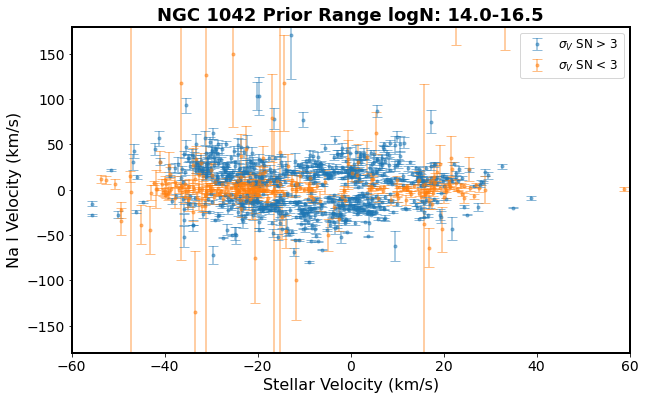

In [77]:
pl.title(r'NGC 1042 Prior Range logN: 14.0-16.5')
#pl.scatter(logN_prior1, gas_velocity_prior1,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.scatter(logN_prior2, gas_velocity_prior2,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
#pl.errorbar(logN_prior3, gas_velocity_prior3,label =,alpha=0.3)
pl.errorbar(stellar_velocity_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(stellar_velocity_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.ylim(-180,180)
pl.xlabel(r'Stellar Velocity (km/s)')
pl.ylabel(r'Na I Velocity (km/s)')
pl.xlim(-60,60)
pl.legend(fontsize='large');

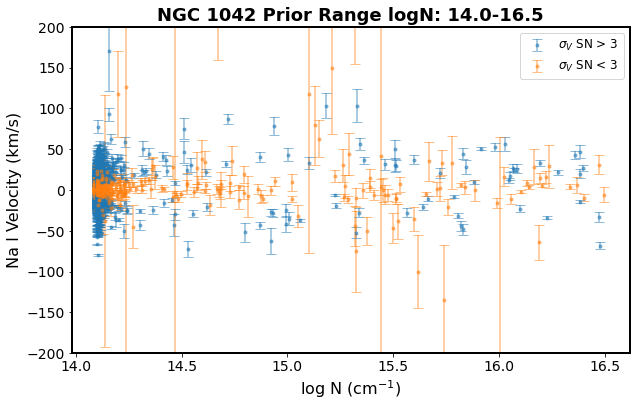

In [72]:
pl.title(r'NGC 1042 Prior Range logN: 14.0-16.5')
#pl.scatter(logN_prior1, gas_velocity_prior1,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.scatter(logN_prior2, gas_velocity_prior2,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
#pl.errorbar(logN_prior3, gas_velocity_prior3,label =,alpha=0.3)
pl.errorbar(logN_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(logN_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.xlabel(r'log N (cm$^{-1}$)')
pl.ylabel(r'Na I Velocity (km/s)')
pl.ylim(-200,200)
pl.legend(fontsize='large');

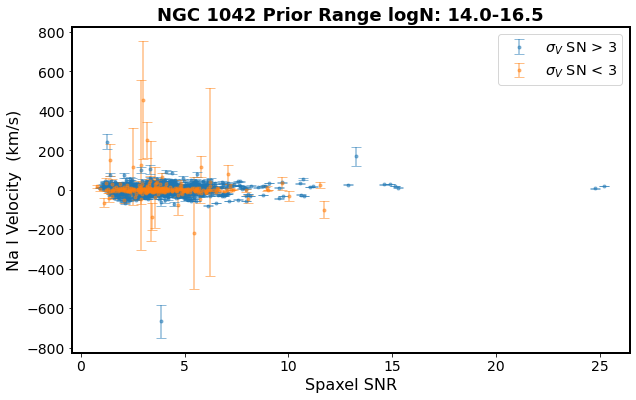

In [78]:
pl.title(r'NGC 1042 Prior Range logN: 14.0-16.5')
#pl.errorbar(snr_spxl_prior1,gas_velocity_prior1,
#yerr=sigma_vel_prior1,fmt=".",capsize=5,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.errorbar(snr_spxl_prior2,gas_velocity_prior2,
#yerr=sigma_vel_prior2,fmt=".",capsize=5,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
pl.errorbar(snr_spxl_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(snr_spxl_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.xlabel('Spaxel SNR')
pl.ylabel(r'Na I Velocity  (km/s)')
pl.legend(fontsize='x-large');

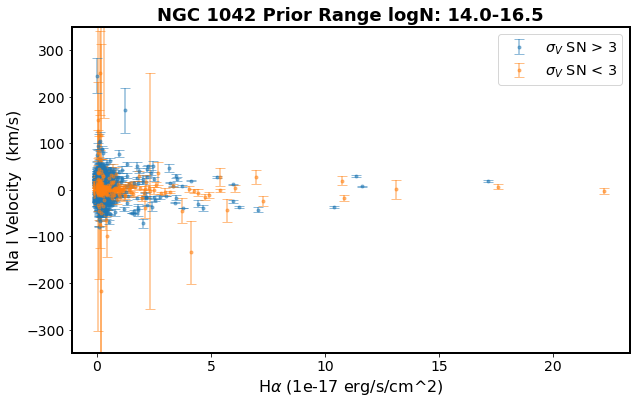

In [74]:
pl.title(r'NGC 1042 Prior Range logN: 14.0-16.5')
#pl.errorbar(snr_spxl_prior1,gas_velocity_prior1,
#yerr=sigma_vel_prior1,fmt=".",capsize=5,label ='Prior Range logN: 11.4-16.0',alpha=0.7)
#pl.errorbar(snr_spxl_prior2,gas_velocity_prior2,
#yerr=sigma_vel_prior2,fmt=".",capsize=5,label ='Prior Range logN: 14.0-16.5',alpha=0.5)
pl.errorbar(halpha_prior2[sig3_greater2],gas_velocity_prior2[sig3_greater2],
            yerr=sigma_vel_prior2[sig3_greater2],fmt=".",capsize=5,label =r'$\sigma_V$ SN > 3',
            alpha = 0.5)
pl.errorbar(halpha_prior2[sig3_less2],gas_velocity_prior2[sig3_less2],
            yerr=sigma_vel_prior2[sig3_less2],fmt=".",capsize=5,label =r'$\sigma_V$ SN < 3',
            alpha = 0.5)
pl.ylim(-350,350)
pl.xlabel(r'H$\alpha$ (1e-17 erg/s/cm^2)')
pl.ylabel(r'Na I Velocity  (km/s)')
pl.legend(fontsize='x-large');

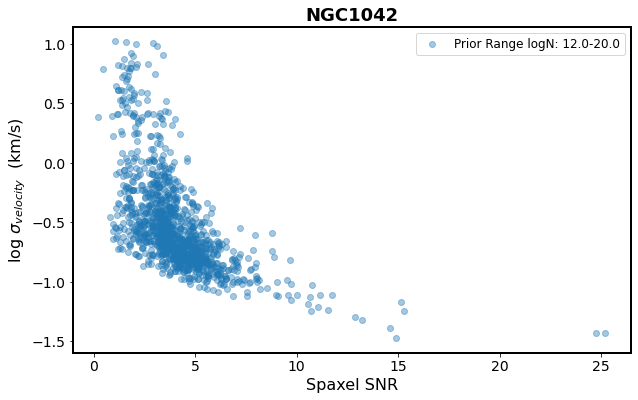

In [186]:
pl.title(r'NGC1042')
pl.scatter(snr_spxl_prior3,np.log10(sigma_lamb_prior3),label ='Prior Range logN: 12.0-20.0',alpha=0.4)
pl.xlabel('Spaxel SNR')
pl.ylabel(r'log $\sigma_{velocity}$  (km/s)')
pl.legend(fontsize='large');

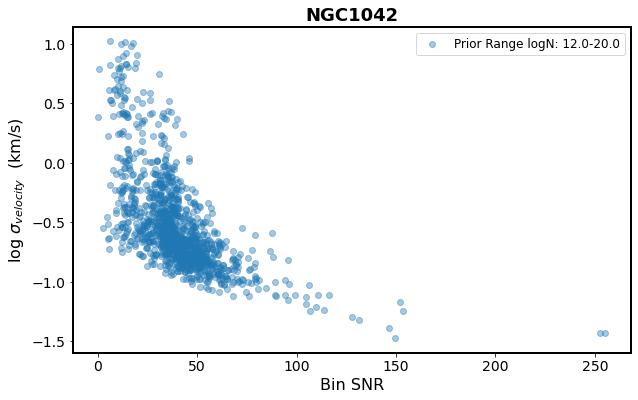

In [185]:
pl.title(r'NGC1042')
pl.scatter(snr_bin_prior3,np.log10(sigma_lamb_prior3),label ='Prior Range logN: 12.0-20.0',alpha=0.4)
pl.xlabel('Bin SNR')
pl.ylabel(r'log $\sigma_{velocity}$  (km/s)')
pl.legend(fontsize='large');

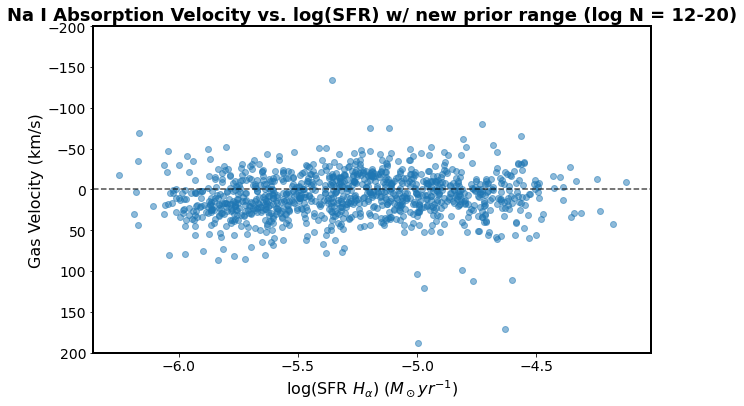

In [138]:
pl.title('Na I Absorption Velocity vs. log(SFR) w/ new prior range (log N = 12-20)')
pl.scatter(logSFR_prior3,gas_velocity_prior3,alpha=0.5)
pl.ylabel('Gas Velocity (km/s)')
pl.xlabel(r'log(SFR $H_\alpha$) ($M_\odot yr^{-1}$)')
pl.ylim(200,-200)
pl.axhline(0,c='k',ls='--',alpha=0.7);

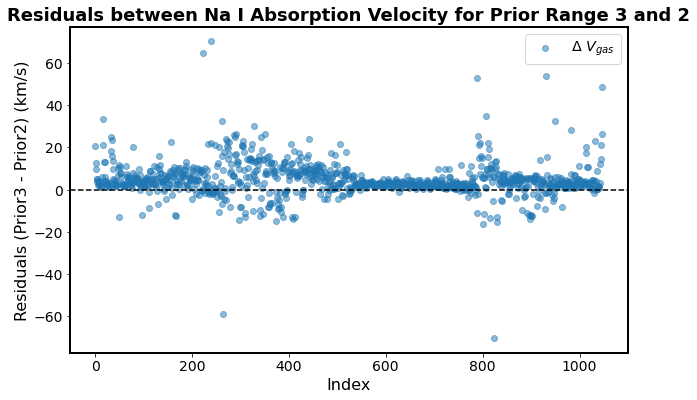

In [152]:
# x = np.arange(-200,201)

# #find line of best fit
# a, b = np.polyfit(gas_velocity_prior1,gas_velocity_prior2, 1)

pl.scatter(np.arange(0,gas_velocity_prior2.size),(gas_velocity_prior3-gas_velocity_prior2),alpha=0.5,label=r'$\Delta$ $V_{gas}$')
#pl.plot(x,x,ls='--',c='k',label='1-1 Line')
#pl.plot(x,a*x + b, c='k', label='Best-fit line')
pl.xlabel('Index')
#pl.ylabel('Gas Velocity (Prior2) (km/s)')
pl.title('Residuals between Na I Absorption Velocity for Prior Range 3 and 2')
pl.ylabel('Residuals (Prior3 - Prior2) (km/s)')
pl.legend(fontsize='x-large')
pl.axhline(0,c='k',ls='--');
#print('Best-Fit Line to the data : y = {:.2f}x {:.2f}'.format(a,b))

Text(0.5, 0, '$V_3 - V_1$ (km/s)')

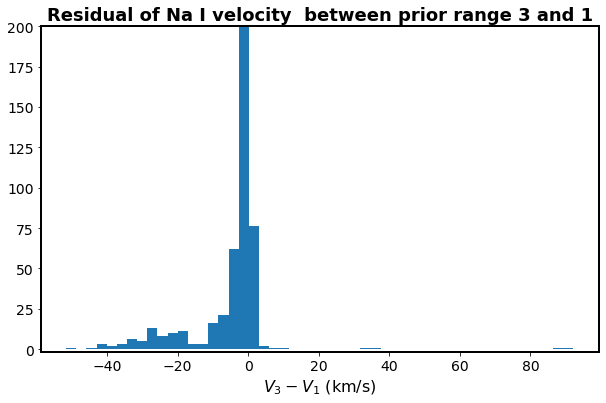

In [169]:
pl.hist((gas_velocity_prior3-gas_velocity_prior1).flatten(), bins = 50)
pl.title('Residual of Na I velocity  between prior range 3 and 1')
pl.ylim(-2,200)
pl.xlabel(r'$V_3 - V_1$ (km/s)')

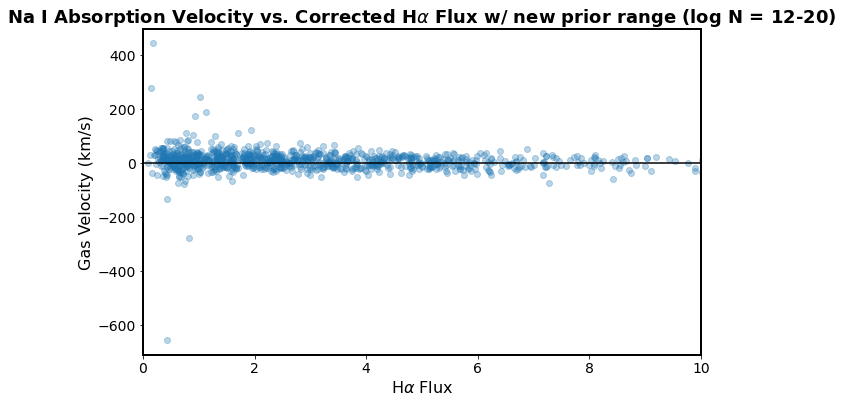

In [153]:
pl.scatter(halpha_prior3,gas_velocity_prior3,alpha=0.3)
pl.title(r'Na I Absorption Velocity vs. Corrected H$\alpha$ Flux w/ new prior range (log N = 12-20)')
pl.xlim(0,10)
#pl.ylim(100,-100)
pl.xlabel(r'H$\alpha$ Flux')
pl.axhline(0,c='k')
pl.ylabel('Gas Velocity (km/s)');

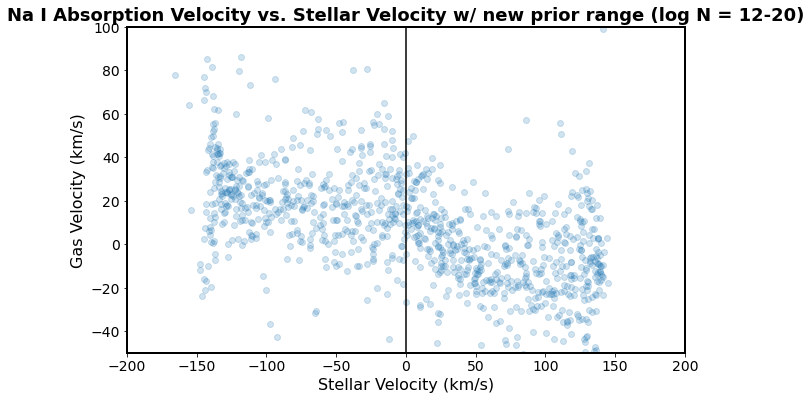

In [141]:
pl.scatter(stellar_velocity_prior3,gas_velocity_prior3,alpha=0.2)
pl.title('Na I Absorption Velocity vs. Stellar Velocity w/ new prior range (log N = 12-20)')
pl.ylabel(r'Gas Velocity (km/s)')
pl.xlabel('Stellar Velocity (km/s)')
pl.ylim(-50,100)
pl.axvline(0,c='k')
pl.xlim(-200,200);

In [172]:
LSFdir = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
LSFfil = LSFdir + 'LSF-Config_MUSE_WFM'
configLSF = np.genfromtxt(LSFfil, comments='#')
configLSF_wv_air = configLSF[:,0]
configLSF_res = configLSF[:,1]

# convert to vacuum since LSF is in air
xspec = XSpectrum1D.from_tuple((configLSF_wv_air, 0.0*configLSF_wv_air))
xspec.meta['airvac'] = 'air'
xspec.airtovac()
configLSF_wv_vac = xspec.wavelength.value

configLSF_restwv = configLSF_wv_vac / (1.0+redshift)
whLSF = np.where((configLSF_restwv > fitlim[0]) & (configLSF_restwv < fitlim[1]))

median_LSFAng = np.median(configLSF_res[whLSF[0]])
median_LSFvel = c * median_LSFAng / np.median(configLSF_wv_vac[whLSF[0]])
LSFvel = median_LSFvel

/Users/erickaguirre/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [528]:
def NaImcmc(binid, redshift, binid_map, stellar_vel, flux, error, obswave,LSFvel,table):
    # Na I doublet vacuum absorption wavelengths 
    D1 = 5891.582 # in angstroms
    D2 = 5897.558 # in angstroms
    
    ind = binid_map == binid
    # single bin velocity
    binvel = stellar_vel[ind][0]
    # single flux, error and model spectrum corresponding to that bin 
    flux_bin = np.ma.array(flux[:,ind][:,0])
    err_bin = np.ma.array(error[:,ind][:,0])
    mod_bin = np.ma.array(model[:,ind][:,0])

    # Determine bin redshift:
    bin_z = redshift + ((1 + redshift) * binvel / c)
    restwave = obswave / (1.0 + bin_z)

    ndata = continuum_normalize_NaI.norm(restwave, flux_bin, err_bin, blim, rlim, FIT_FLG=0)
    ndata_mod = continuum_normalize_NaI.norm(restwave, mod_bin, err_bin, blim, rlim, FIT_FLG=0)
    # Cut out NaI
    select = np.where((ndata['nwave'] > fitlim[0]) & (ndata['nwave'] < fitlim[1]))
    select_mod = np.where((ndata_mod['nwave'] > fitlim[0]) & (ndata_mod['nwave'] < fitlim[1]))
    restwave_NaI = ndata['nwave'][select].astype('float64')
    flux_NaI = ndata['nflux'][select].astype('float64')
    err_NaI = ndata['nerr'][select].astype('float64')
    sres_NaI = LSFvel
    mod_NaI = ndata_mod['nflux'][select_mod].astype('float64')
    vel_NaI = c * ((restwave_NaI/D1) - 1)

    data = {'wave':restwave_NaI, 'flux':flux_NaI, 'model':mod_NaI, 'err':err_NaI, 
            'velres':sres_NaI,'velocity':vel_NaI}
    binid_indx = table['bin'] == binid
    model_fit_bin = model_NaI.model_NaI(table['percentiles'][binid_indx][0][:,0], data['velres'], data['wave'])
    print('velocity:',table['velocities'][binid_indx][0])
    cent_vel = table['velocities'][binid_indx][0]
    return flux_bin, restwave,data, model_fit_bin,cent_vel

In [215]:
def get_info(bin_ids=None,spaxel_locx=None,spaxel_locy=None):
    if bin_ids != None:
        for bin_ in bin_ids:
            bin_id = np.where(binid_map == bin_)
            print('['+str(bin_id[0][0])+','+str(bin_id[1][0])+']')
    if ((spaxel_locx != None) & (spaxel_locy != None)):
        print(binid_map[spaxel_locx,spaxel_locy])

In [226]:
get_info(bin_ids=None,spaxel_locx=97,spaxel_locy=97)

373


No handles with labels found to put in legend.


velocity: -75.47574251186934


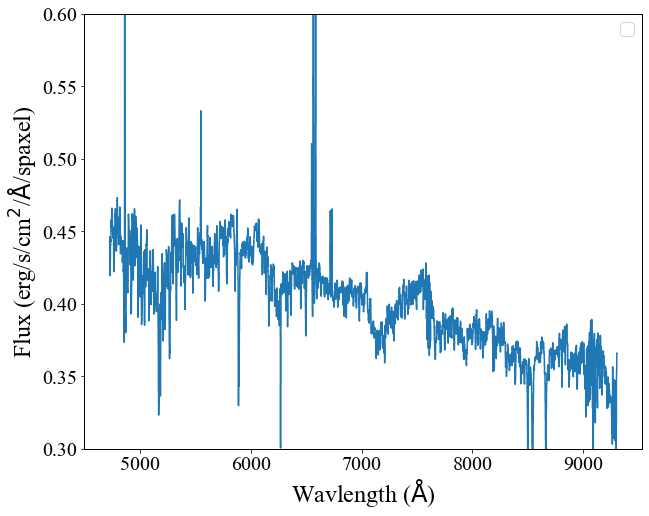

In [525]:
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms

flux_bin, restwave,data_NaI, model_fit_bin_NaI,cent_vel = NaImcmc(19, redshift, binid_map, stellar_vel, 
                                      flux, error, wave,LSFvel,table_prior4)

pl.step(restwave,flux_bin)
# pl.plot(data_NaI['velocity'],data_NaI['model'],label='S.C Model')
# pl.plot(data_NaI['velocity'],model_fit_bin_NaI['modflx'],label='Absorption Model')

D1_reg = 5850
D2_reg = 5940
# pl.axvline(x=D1_reg,c='grey',ls='--')
# pl.axvline(x=D2_reg,c='grey',ls='--')
# pl.axvline(x=cent_vel,c='red',ls='--')

pl.ylabel('Flux (erg/s/cm$^2$/$\mathrm{\AA}$/spaxel)',fontsize=24)
pl.xlabel('Wavlength ($\mathrm{\AA}$)',fontsize=24)
pl.legend(fontsize='xx-large')
pl.ylim(0.3,0.6);
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/NaI_spec1.pdf',bbox_inches='tight');

/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/erickaguirre/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


velocity: -75.47574251186934


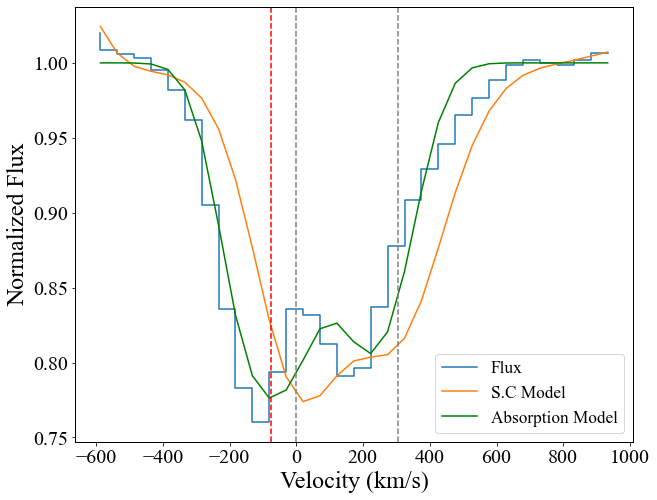

In [529]:
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms

flux_bin, restwave,data_NaI, model_fit_bin_NaI,cent_vel = NaImcmc(19, redshift, binid_map, stellar_vel, 
                                      flux, error, wave,LSFvel,table_prior4)
pl.step(data_NaI['velocity'],data_NaI['flux'],label='Flux')
pl.plot(data_NaI['velocity'],data_NaI['model'],label='S.C Model')
pl.plot(data_NaI['velocity'],model_fit_bin_NaI['modflx'],label='Absorption Model',c='green')

D2_abs = c * ((D2/D1) - 1)
pl.axvline(x=0,c='grey',ls='--')
pl.axvline(x=D2_abs,c='grey',ls='--')
pl.axvline(x=cent_vel,c='red',ls='--')

pl.ylabel('Normalized Flux',fontsize=24)
pl.xlabel('Velocity (km/s)',fontsize=24)
pl.legend(fontsize='xx-large');
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/NaI_regular4.pdf',bbox_inches='tight');

/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/erickaguirre/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


velocity: -75.47574251186934


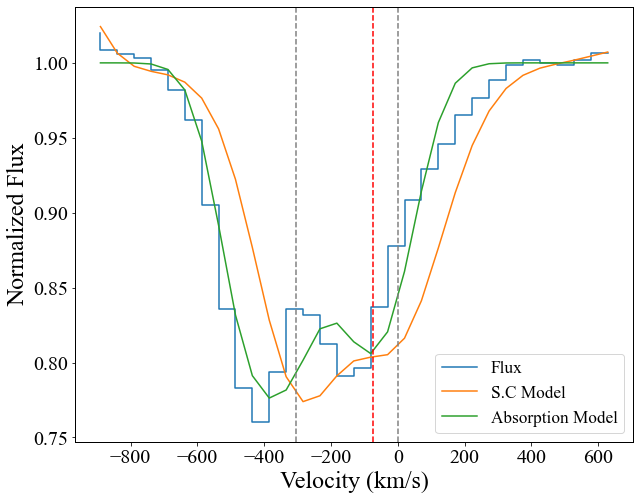

In [231]:
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms

data_NaI, model_fit_bin_NaI,cent_vel = NaImcmc(19, redshift, binid_map, stellar_vel, 
                                      flux, error, wave,LSFvel,table_prior4)
pl.step(data_NaI['velocity'],data_NaI['flux'],label='Flux')
pl.plot(data_NaI['velocity'],data_NaI['model'],label='S.C Model')
pl.plot(data_NaI['velocity'],model_fit_bin_NaI['modflx'],label='Absorption Model')

D1_abs = c * ((D1/D2) - 1)
pl.axvline(x=0,c='grey',ls='--')
pl.axvline(x=D1_abs,c='grey',ls='--')
pl.axvline(x=cent_vel,c='red',ls='--')

pl.ylabel('Normalized Flux',fontsize=24)
pl.xlabel('Velocity (km/s)',fontsize=24)
pl.legend(fontsize='xx-large');
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/NaI_regular4.pdf',bbox_inches='tight');

In [244]:
get_info(bin_ids=None,spaxel_locx=108,spaxel_locy=156)

276


/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/erickaguirre/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


velocity: 60.55974783811568


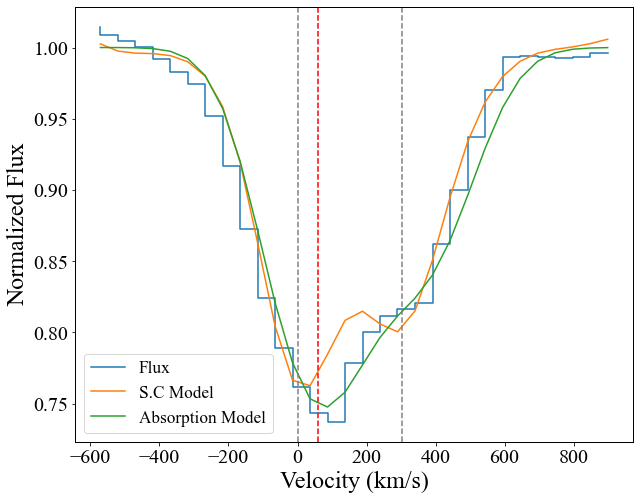

In [530]:
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms

flux_bin, restwave,data_NaI, model_fit_bin_NaI,cent_vel = NaImcmc(276, redshift, binid_map, stellar_vel, 
                                      flux, error, wave,LSFvel,table_prior4)
pl.step(data_NaI['velocity'],data_NaI['flux'],label='Flux')
pl.plot(data_NaI['velocity'],data_NaI['model'],label='S.C Model')
pl.plot(data_NaI['velocity'],model_fit_bin_NaI['modflx'],label='Absorption Model')

D1_abs = c * ((D2/D1) - 1)
pl.axvline(x=0,c='grey',ls='--')
pl.axvline(x=D1_abs,c='grey',ls='--')
pl.axvline(x=cent_vel,c='red',ls='--')

pl.ylabel('Normalized Flux',fontsize=24)
pl.xlabel('Velocity (km/s)',fontsize=24)
pl.legend(fontsize='xx-large',loc='lower left');
pl.savefig('/Users/erickaguirre/Desktop/presentation_slides/NaI_inflow.pdf',bbox_inches='tight');